# Beta cells

## load data

In [1]:

import sys
import pickle
import pandas as pd
import scanpy as sc
# 将点大小设为该通路在adata中存在的基因数（归一化到可视范围）
import numpy as np
import matplotlib.pyplot as plt
import os
sys.path.append('./model/')  # 添加model文件夹到路径

plt.rcParams['pdf.fonttype'] = 42

def load_results(cell_type,n_top=5):
    with open(f'./results/real_exp/processed_hpap/scKnockPath_results/scKnockPath_ND_AAB+_{cell_type}.pkl', 'rb') as f:
        model = pickle.load(f)
    
    print(f'scKnockPath selects {len(model.select_pathway(0.2))} pathways under FDR 0.2')
    
    # 定义结果文件路径
    results_base = './results/real_exp/processed_hpap'
    methods_results = {}
    
    # PADOG结果
    padog_file = os.path.join(results_base, f'PADOG_results/PADOG_AAB+_vs_ND_{cell_type}.csv')
    if os.path.exists(padog_file):
        padog_results = pd.read_csv(padog_file)
        methods_results['PADOG'] = padog_results
        print(f"✅ PADOG结果加载成功: {padog_results.shape[0]} 通路")
    else:
        print(f"❌ PADOG结果文件未找到: {padog_file}")

    # GSEA结果
    gsea_file = os.path.join(results_base, f'GSEA_results/GSEA_{cell_type}_AAB+_vs_ND.csv')
    if os.path.exists(gsea_file):
        gsea_results = pd.read_csv(gsea_file)
        methods_results['GSEA'] = gsea_results
        print(f"✅ GSEA结果加载成功: {gsea_results.shape[0]} 通路")
    else:
        print(f"❌ GSEA结果文件未找到: {gsea_file}")

    # CAMERA结果
    camera_file = os.path.join(results_base, f'CAMERA_results/CAMERA_AAB+_vs_ND_{cell_type}.csv')
    if os.path.exists(camera_file):
        camera_results = pd.read_csv(camera_file)
        methods_results['CAMERA'] = camera_results
        print(f"✅ CAMERA结果加载成功: {camera_results.shape[0]} 通路")
    else:
        print(f"❌ CAMERA结果文件未找到: {camera_file}")

    # SCPA结果
    scpa_file = os.path.join(results_base, f'SCPA_results/SCPA_AAB+_vs_ND_{cell_type}.csv')
    if os.path.exists(scpa_file):
        scpa_results = pd.read_csv(scpa_file)
        methods_results['SCPA'] = scpa_results
        print(f"✅ SCPA结果加载成功: {scpa_results.shape[0]} 通路")
    else:
        print(f"❌ SCPA结果文件未找到: {scpa_file}")

    # scKP结果
    methods_results['scKnockPath'] = pd.DataFrame(model.rank_pathways()[::-1][:len(model.select_pathway(0.2))]['pathway_names']).rename(columns={'pathway_names':'Pathway'})
    print(f"\n总共加载了 {len(methods_results)} 种方法的结果")

    top_by_method = {}
    all_top_pathways = set()
    for method, df in methods_results.items():
        if method == 'GSEA':
            top = df['Term'].head(n_top).tolist()
        else:
            top = df['Pathway'].head(n_top).tolist()
        top_by_method[method] = top
        all_top_pathways.update(top)

    return top_by_method, model, all_top_pathways, methods_results

cell_type = 'Beta'
top_by_method, model, all_top_pathways, methods_results = load_results(cell_type,n_top=5)
# top_by_method, model, all_top_pathways, methods_results

scKnockPath selects 16 pathways under FDR 0.2
✅ PADOG结果加载成功: 44 通路
✅ GSEA结果加载成功: 112 通路
✅ CAMERA结果加载成功: 5 通路
✅ SCPA结果加载成功: 100 通路

总共加载了 5 种方法的结果


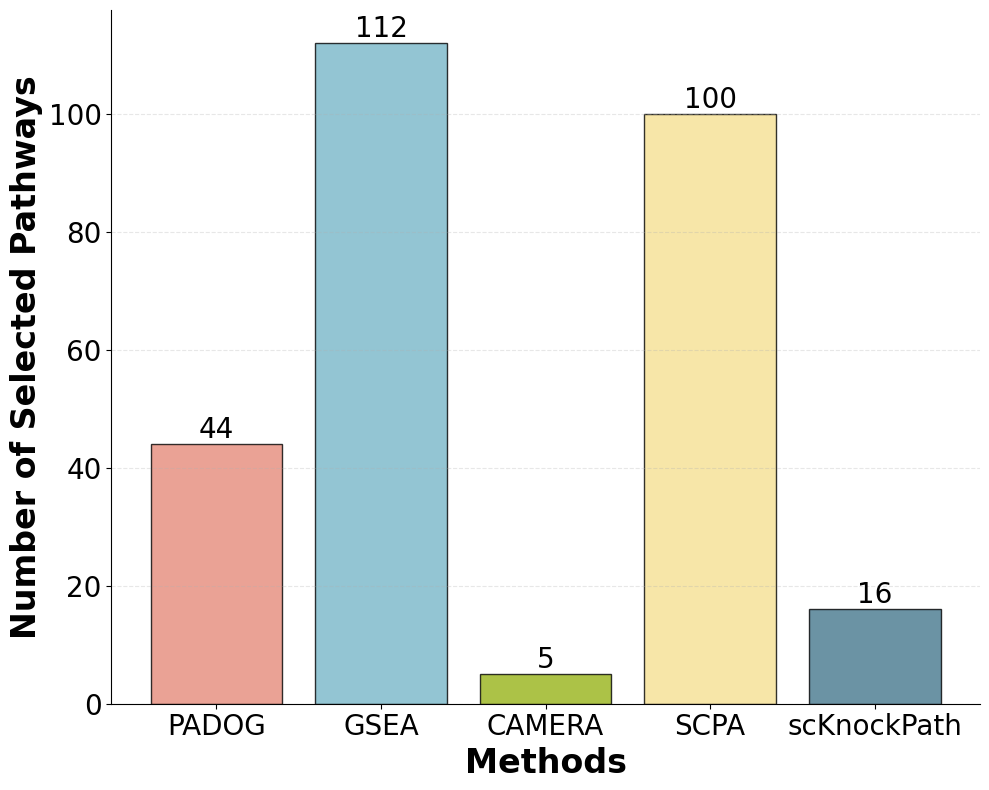

In [2]:
import matplotlib.pyplot as plt

# Extract counts for each method
counts = {method: len(df) for method, df in methods_results.items()}
colors = ['#E58B7B','#78B7C9','#97B319', '#F6E093','#46788E']

# Create bar plot
plt.figure(figsize=(10,8))
bars = plt.bar(counts.keys(), counts.values(), color=colors, edgecolor='black', alpha=0.8)

tick_fontsize = 20
label_fontsize = 24
# Add text labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=tick_fontsize)

plt.ylabel('Number of Selected Pathways', fontsize=label_fontsize,weight='bold')
plt.xlabel('Methods', fontsize=label_fontsize,weight='bold')

plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig(f'./results/real_exp/processed_hpap/{cell_type}_pathway_counts_bar.pdf')
plt.show()


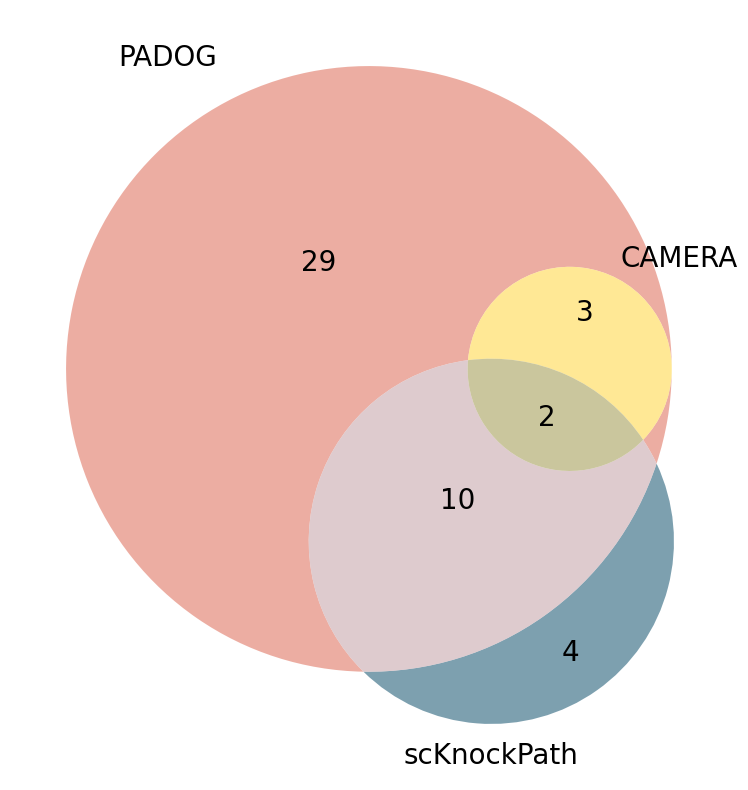

In [3]:
from matplotlib_venn import venn3

import matplotlib.pyplot as plt

# Extract sets of pathways for the three methods
padog_pathways = set(methods_results['PADOG']['Pathway'])
camera_pathways = set(methods_results['CAMERA']['Pathway'])
sckp_pathways = set(methods_results['scKnockPath']['Pathway'])

# Plot Venn diagram
plt.figure(figsize=(8, 8))
colors = ['#E58B7B','#97B319','#46788E']
v = venn3([padog_pathways, camera_pathways, sckp_pathways], 
    set_labels=('PADOG', 'CAMERA', 'scKnockPath'),set_colors=colors, alpha=0.7,)

# Increase font size for set labels and subset numbers
for text in v.set_labels:
    if text: text.set_fontsize(20)
for text in v.subset_labels:
    if text: text.set_fontsize(20)

plt.tight_layout()
plt.savefig(f'./results/real_exp/processed_hpap/venn_padog_camera_scknockpath_{cell_type}.pdf')
plt.show()

## W scores

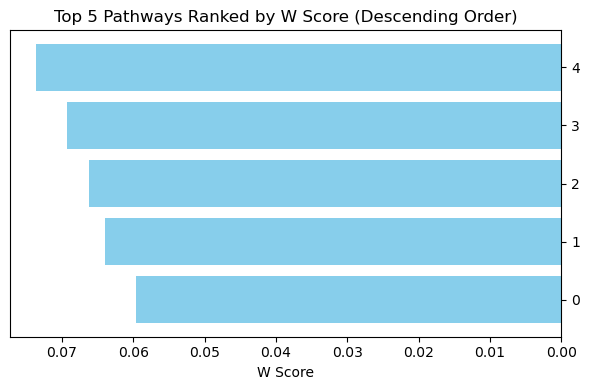

In [4]:
import matplotlib.pyplot as plt

# Get the ranked pathways in descending order
ranked = model.rank_pathways()[-5:]

# replace long pathway names with short ones for better visualization
short_names = {
    'REACTOME_REGULATION_OF_INSULIN_LIKE_GROWTH_FACTOR_IGF_TRANSPORT_AND_UPTAKE_BY_INSULIN_LIKE_GROWTH_FACTOR_BINDING_PROTEINS_IGFBPS':'REACTOME_INSULIN_IGFBPS*',
    'REACTOME_NUCLEAR_EVENTS_KINASE_AND_TRANSCRIPTION_FACTOR_ACTIVATION':'REACTOME_KINASE_AND_TRANSCRIPTION_FACTOR*',
    'REACTOME_IMMUNOREGULATORY_INTERACTIONS_BETWEEN_A_LYMPHOID_AND_A_NON_LYMPHOID_CELL':'REACTOME_INTERACTIONS_LYMPHOID*'
}

# Assuming 'ranked' is a DataFrame with columns like 'pathway_names' and 'scores'
# If it's a dict, adjust accordingly
if hasattr(ranked, 'columns'):
    pathways = ranked['pathway_names'] if 'pathway_names' in ranked.columns else ranked.index
    scores = ranked['scores'] if 'scores' in ranked.columns else ranked.values
else:
    pathways = list(ranked.keys())
    scores = list(ranked.values())

# Apply short names mapping
short_pathways = [short_names.get(p, p) for p in pathways]

# Further shorten for display by removing prefixes
display_labels = [p.replace('REACTOME_', '').replace('KEGG_', '') for p in short_pathways]

# Plot horizontal bar chart
plt.figure(figsize=(6, 4))
plt.barh(range(len(display_labels)), scores, color='skyblue')
# plt.yticks(range(len(display_labels)), display_labels, fontsize=10)
plt.xlabel('W Score')
plt.title('Top 5 Pathways Ranked by W Score (Descending Order)')

# Reverse the x-axis and move y-ticks to the right
ax = plt.gca()
ax.invert_xaxis()
ax.yaxis.set_ticks_position('right')
ax.yaxis.set_label_position('right')

plt.tight_layout()
plt.savefig(f'./results/real_exp/processed_hpap/{cell_type}_top5_pathways_wscore.pdf')
plt.show()

In [3]:
# Get the top pathways from scKnockPath
top_pathways = ranked['pathway_names'].tolist()

# Methods to check ranks in
other_methods = ['PADOG', 'GSEA', 'CAMERA', 'SCPA']

# Initialize the result dict
pathway_ranks = {}

for pathway in top_pathways:
    ranks = {}
    for method in other_methods:
        df = methods_results[method]
        col = 'Term' if method == 'GSEA' else 'Pathway'
        if pathway in df[col].values:
            rank = df[col].tolist().index(pathway) + 1  # 1-based rank
        else:
            rank = None  # Not in top results
        ranks[method] = rank
    pathway_ranks[pathway] = ranks

pathway_ranks

{'REACTOME_PEPTIDE_HORMONE_METABOLISM': {'PADOG': 15,
  'GSEA': 18,
  'CAMERA': None,
  'SCPA': 35},
 'KEGG_TYPE_I_DIABETES_MELLITUS': {'PADOG': 26,
  'GSEA': 15,
  'CAMERA': 3,
  'SCPA': 34},
 'KEGG_LEUKOCYTE_TRANSENDOTHELIAL_MIGRATION': {'PADOG': 30,
  'GSEA': 102,
  'CAMERA': None,
  'SCPA': 11},
 'REACTOME_REGULATION_OF_INSULIN_LIKE_GROWTH_FACTOR_IGF_TRANSPORT_AND_UPTAKE_BY_INSULIN_LIKE_GROWTH_FACTOR_BINDING_PROTEINS_IGFBPS': {'PADOG': None,
  'GSEA': 78,
  'CAMERA': None,
  'SCPA': 47},
 'REACTOME_INTERFERON_ALPHA_BETA_SIGNALING': {'PADOG': 10,
  'GSEA': 97,
  'CAMERA': None,
  'SCPA': 72}}

## GSEA reuslts

In [ ]:
# plot the GSEA results for REACTOME_REGULATION_OF_INSULIN_LIKE_GROWTH_FACTOR_IGF_TRANSPORT_AND_UPTAKE_BY_INSULIN_LIKE_GROWTH_FACTOR_BINDING_PROTEINS_IGFBPS

import gseapy as gp
def GSEA_test(adata,layer,gs_filepath,gene_names,obs_y,gene_thresh):

    adata.layers['lognorm'] = adata.layers[layer] if layer is not None else adata.X

    if hasattr(adata.layers['lognorm'], "toarray"):
        X = adata.layers['lognorm'].toarray()
    else:
        X = adata.layers['lognorm']
    
    if gene_names is not None: 
        adata.var_names = adata.var[gene_names].astype(str)
    
    df = pd.DataFrame(X, columns=adata.var_names)
    geneset_dict = gp.read_gmt(gs_filepath)
    
    res = gp.gsea(
        data=df.T,
        gene_sets=geneset_dict,
        cls=adata.obs[obs_y],
        permutation_num=1000,
        method='signal_to_noise',
        min_size=gene_thresh,
        seed=42
    )
    
    return res

data_filename='./data/T1D/processed_hpap.h5ad'
cell_type='Beta'
class1='AAB+'
class2='ND'
layer='lognorm'
geneset_path='./data/pathway_db/reactome_kegg.gmt'
gene_thresh=15
gene_names=None
obs_y='diabetes_status'
fdr=0.2

adata=sc.read_h5ad(data_filename)
adata = adata[adata.obs['cell_type'] == cell_type, :]
adata=adata[(adata.obs[obs_y]==class2)|(adata.obs[obs_y]==class1),:]



In [16]:
res=GSEA_test(adata=adata,layer=None,gs_filepath=geneset_path,gene_names=gene_names, obs_y=obs_y, gene_thresh=gene_thresh)

/tmp/ipykernel_1402672/4047266946.py:5: ImplicitModificationWarning: Setting element `.layers['lognorm']` of view, initializing view as actual.
  adata.layers['lognorm'] = adata.layers[layer] if layer is not None else adata.X


In [ ]:
import pickle
with open('results/real_exp/processed_hpap/GSEA_res_Beta.pkl', 'wb') as f:
    pickle.dump(res, f)


In [2]:
with open('results/real_exp/processed_hpap/GSEA_res_Beta.pkl', 'rb') as f:
    res = pickle.load(f)

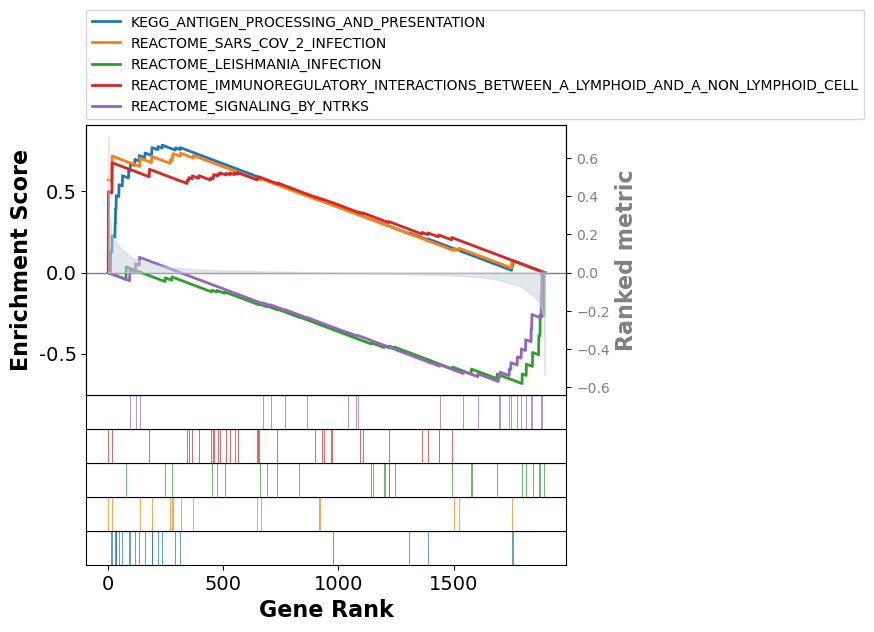

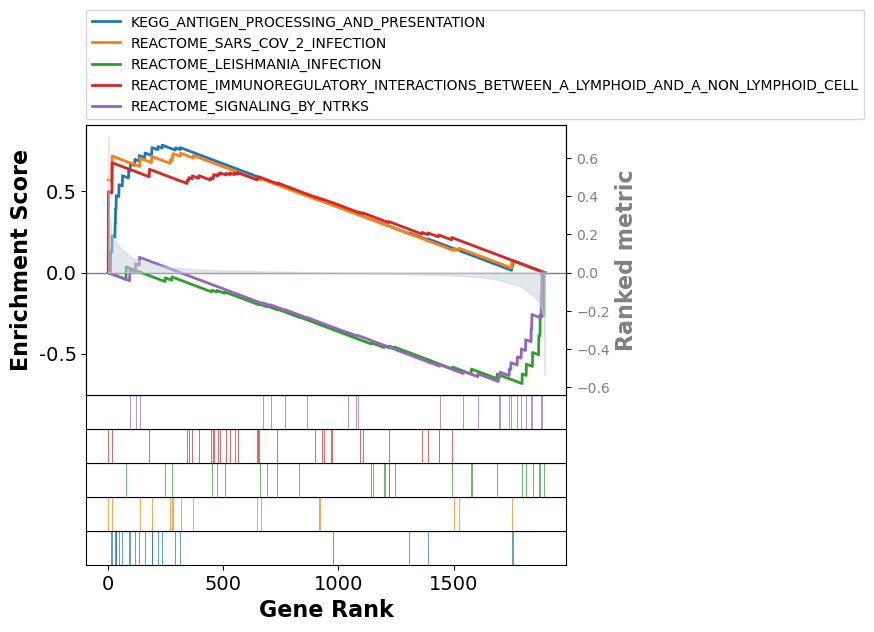

In [17]:
term = res.res2d.Term
res.plot(terms=term[:5])

/tmp/ipykernel_1526993/240145407.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


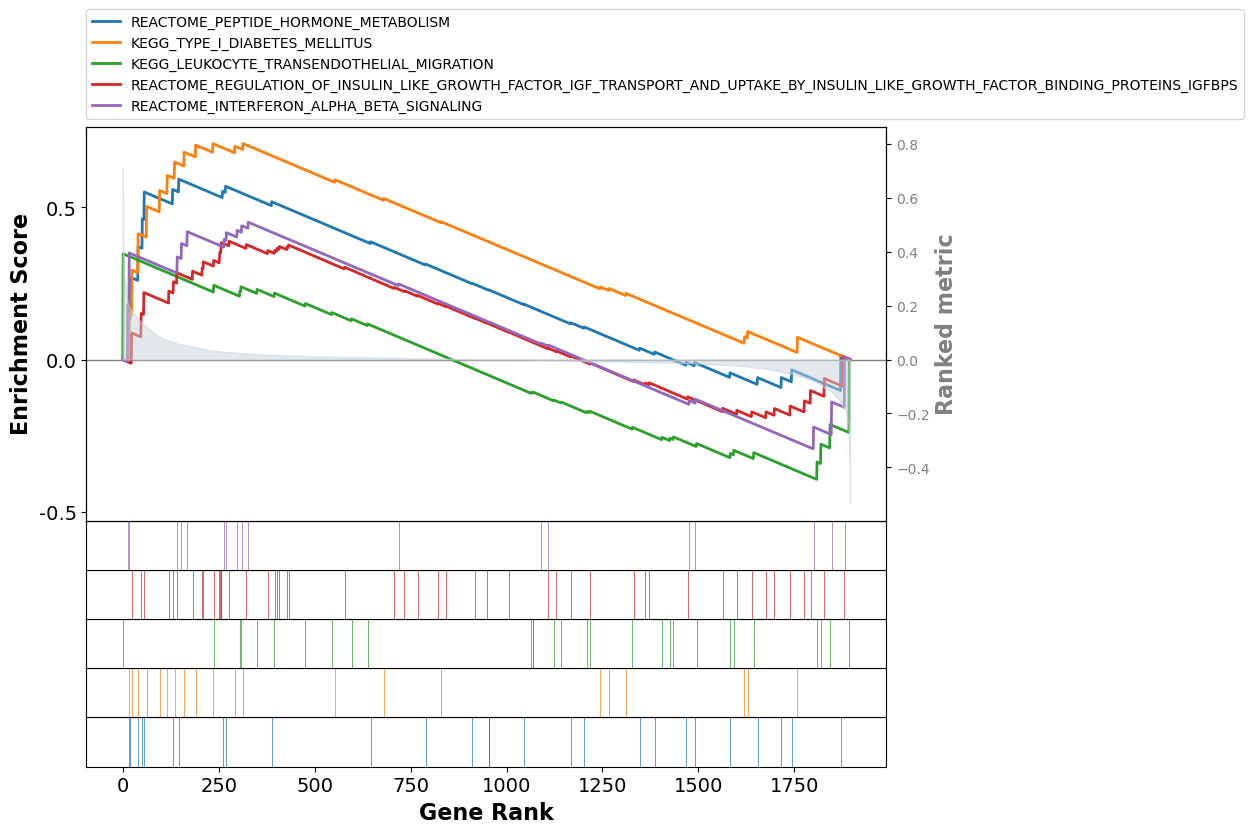

In [ ]:


fig = res.plot(terms=ranked['pathway_names'].tolist())  # 返回的为 matplotlib.figure.Figure

# 可根据需要调整尺寸
fig.set_size_inches(10, 8)

# 保证布局并保存完整内容
fig.tight_layout()
fig.savefig(f'results/real_exp/processed_hpap/{cell_type}_GSEA_top5_pathways.pdf', bbox_inches='tight', pad_inches=0.05, dpi=300)

## Genes Frequency

In [3]:
gene2dict=model.transform_geneset_dict()
# model.pathway_dict

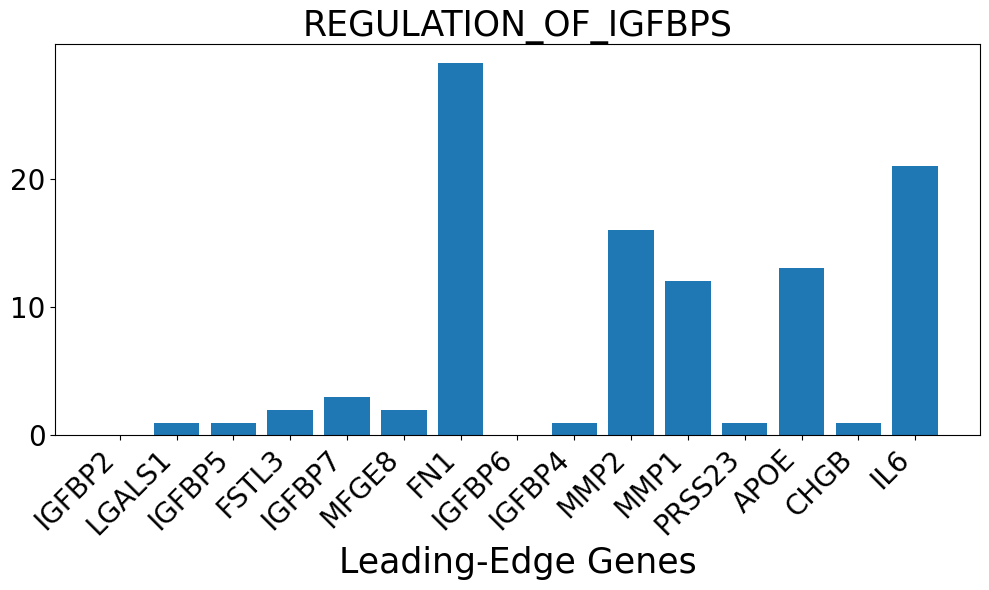

In [13]:
target_pathway='REACTOME_REGULATION_OF_INSULIN_LIKE_GROWTH_FACTOR_IGF_TRANSPORT_AND_UPTAKE_BY_INSULIN_LIKE_GROWTH_FACTOR_BINDING_PROTEINS_IGFBPS'

import matplotlib.pyplot as plt

def plot_leading_edge_genes(res, target_pathway, gene2dict,title=None):
    # Compute the number of other pathways for each gene in DEGs
    DEGs = res.res2d[res.res2d['Term'] == target_pathway]['Lead_genes'].iloc[0].split(';')
    other_pathway_counts = []
    for gene in DEGs:
        pathways = gene2dict.get(gene, [])
        other_pathways = [p for p in pathways if p != target_pathway]
        count = len(other_pathways)
        other_pathway_counts.append(count)

    plt.figure(figsize=(10, 6))
    plt.bar(range(len(DEGs)), other_pathway_counts, tick_label=DEGs)
    plt.xlabel('Leading-Edge Genes',size=25)
    if title:
        plt.title(title,size=25)
    plt.xticks(rotation=45, ha='right', size=20)
    plt.yticks([0,10,20],size=20)
    plt.tight_layout()
title='REGULATION_OF_IGFBPS'
plot_leading_edge_genes(res, target_pathway, gene2dict, title)
plt.savefig(f'results/real_exp/processed_hpap/{cell_type}_{title}_leading_edge_genes_other_pathways.pdf')

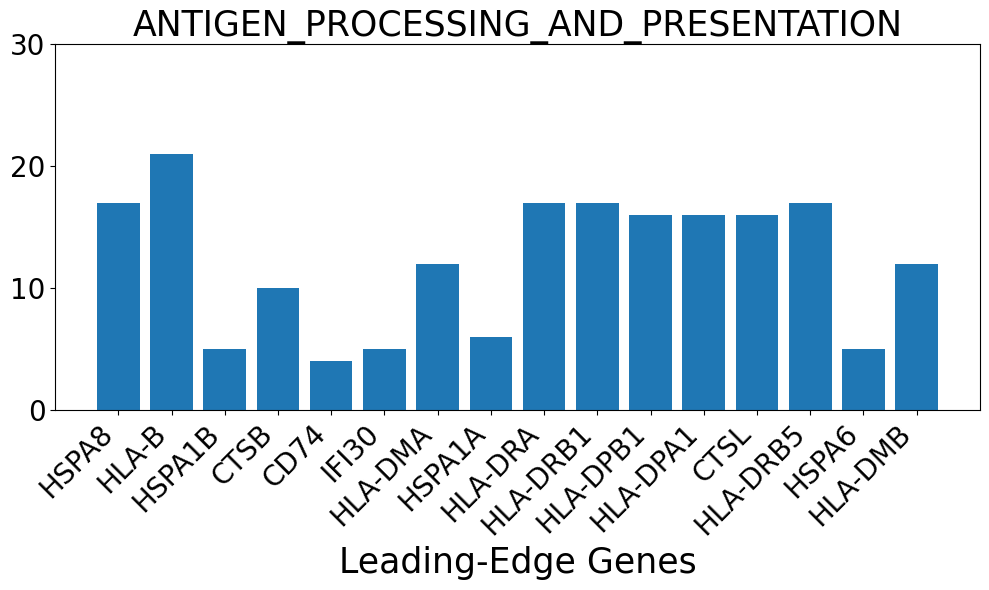

In [32]:
title='ANTIGEN_PROCESSING_AND_PRESENTATION'
target_pathway="KEGG_ANTIGEN_PROCESSING_AND_PRESENTATION"
plot_leading_edge_genes(res, target_pathway, gene2dict, title)
plt.savefig(f'results/real_exp/processed_hpap/{cell_type}_{title}_leading_edge_genes_other_pathways.pdf')

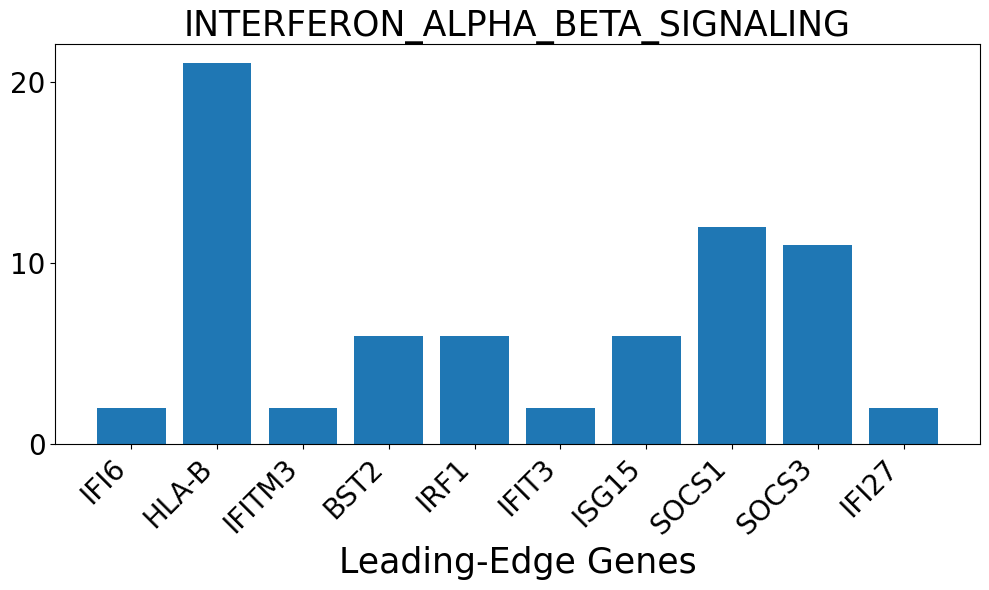

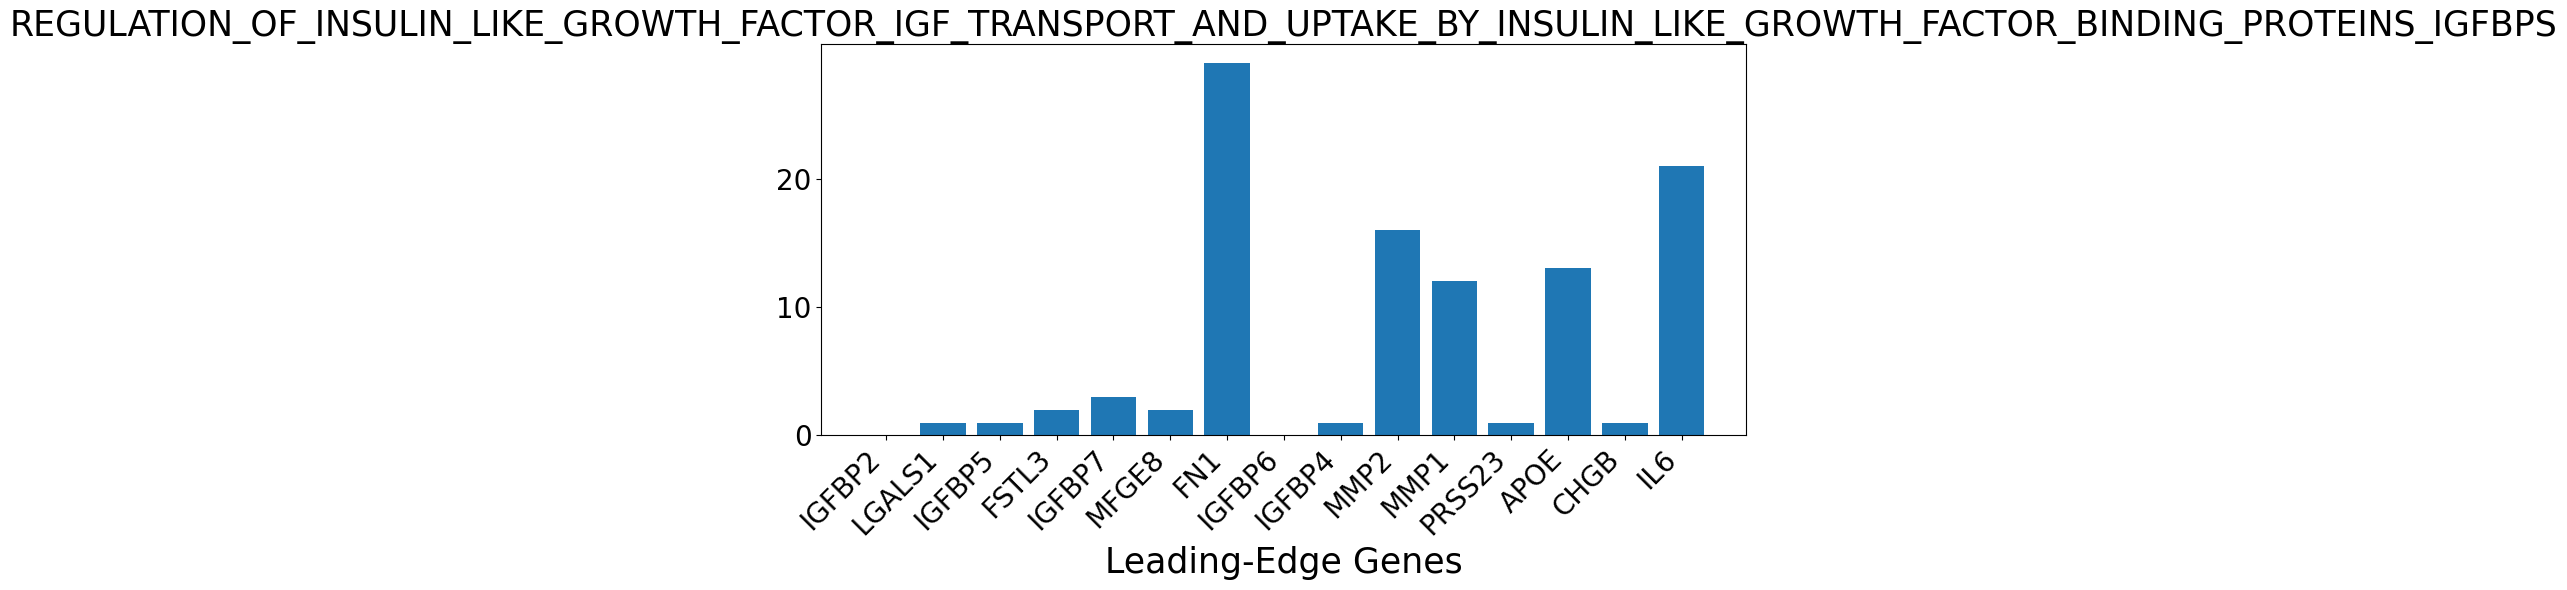

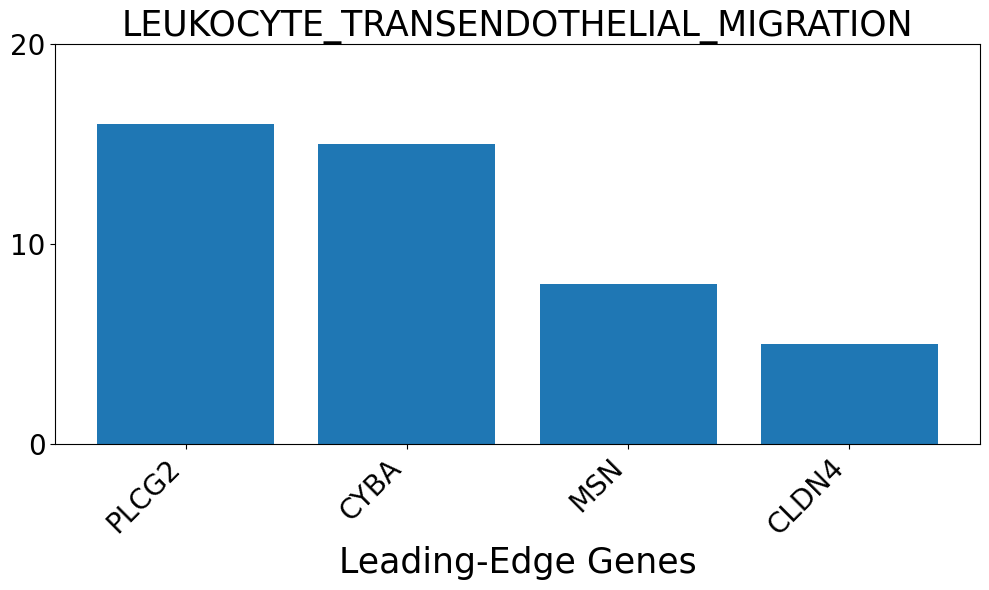

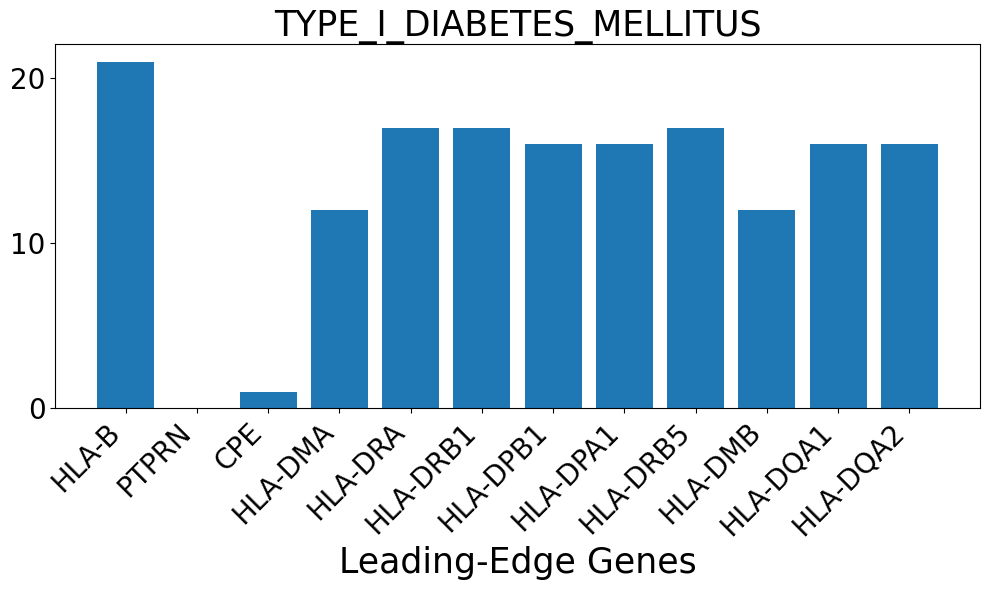

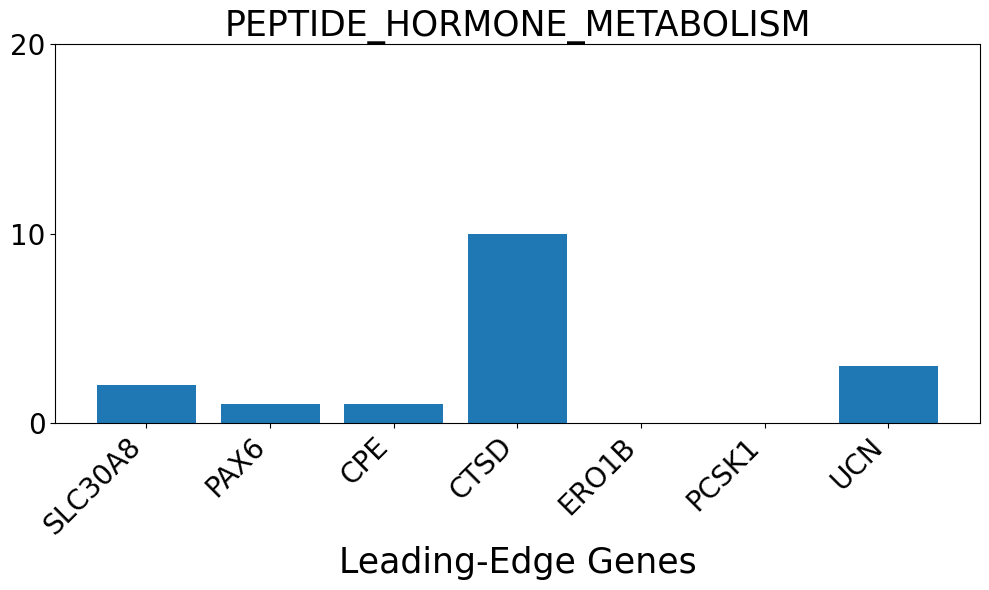

In [14]:

for pathway in top_by_method['scKnockPath']:
    # title='ANTIGEN_PROCESSING_AND_PRESENTATION'
    # delete the prefix KEGG_ or REACTOME_ for better visualization
    if pathway.startswith('KEGG_'):
        title=pathway.replace('KEGG_','')
    elif pathway.startswith('REACTOME_'):
        title=pathway.replace('REACTOME_','')
    else:
        title=pathway
    plot_leading_edge_genes(res, pathway, gene2dict, title)
    plt.savefig(f'results/real_exp/processed_hpap/{cell_type}_{title}_leading_edge_genes_other_pathways.pdf')

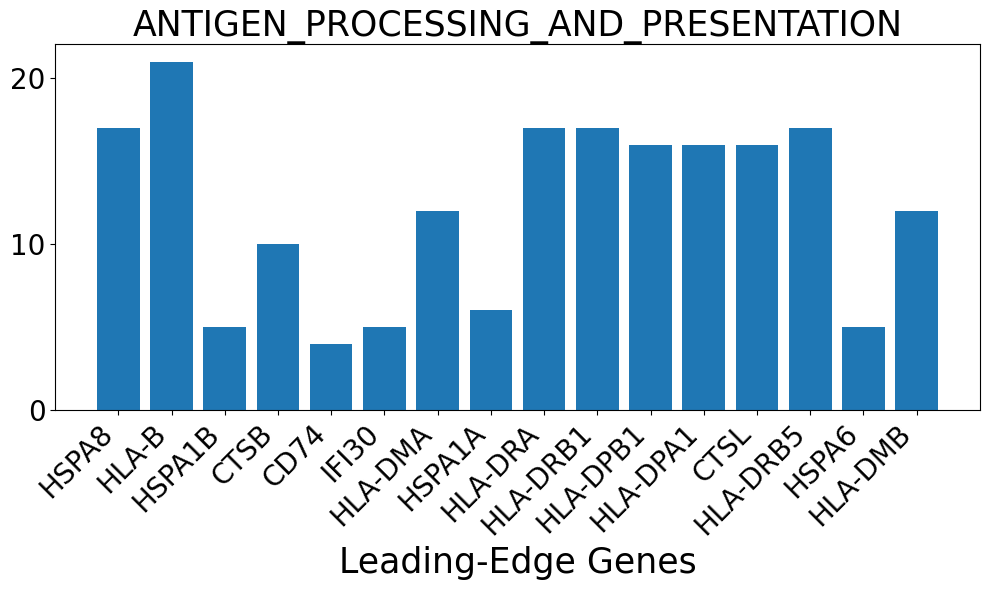

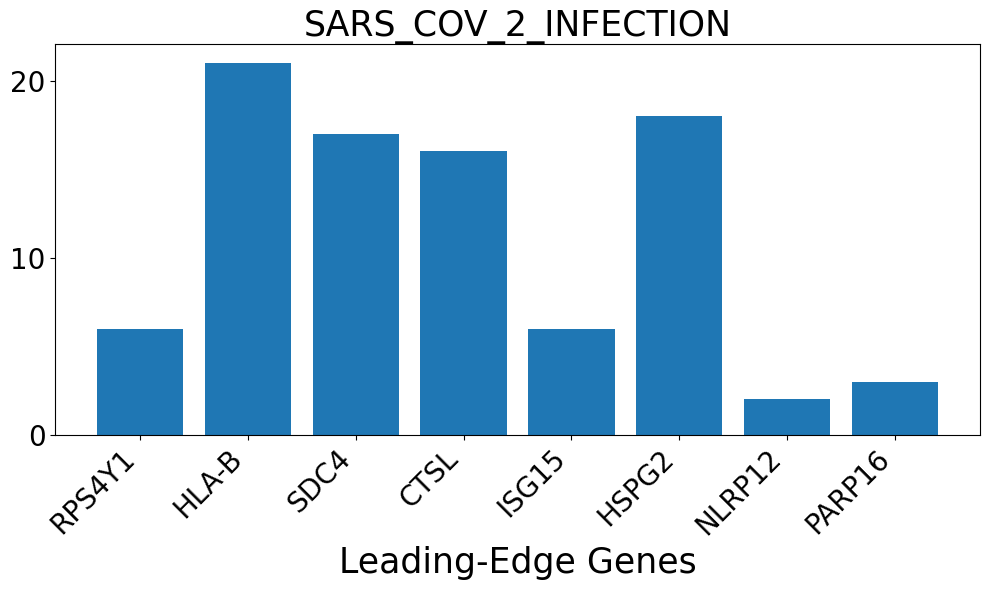

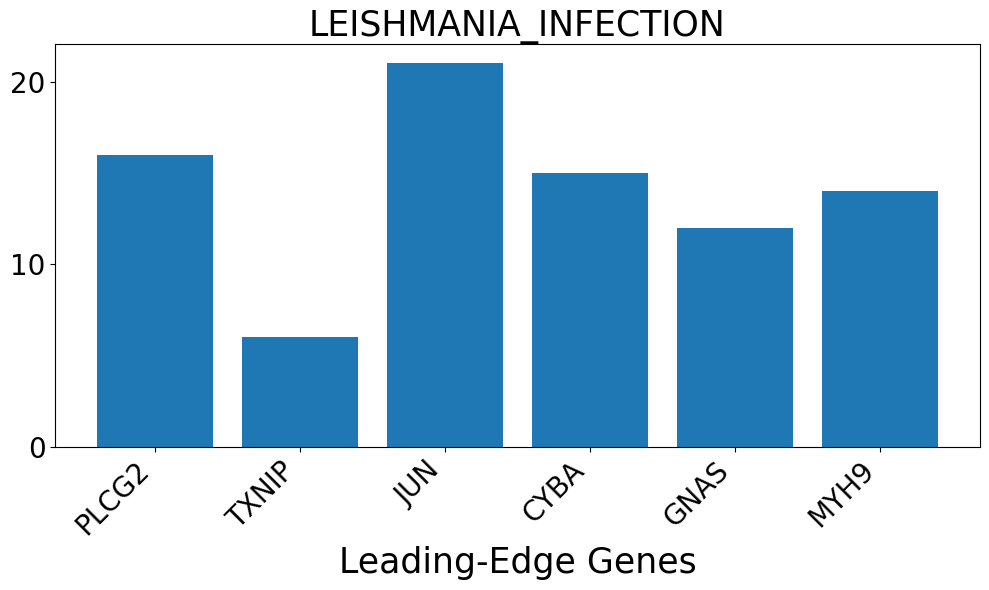

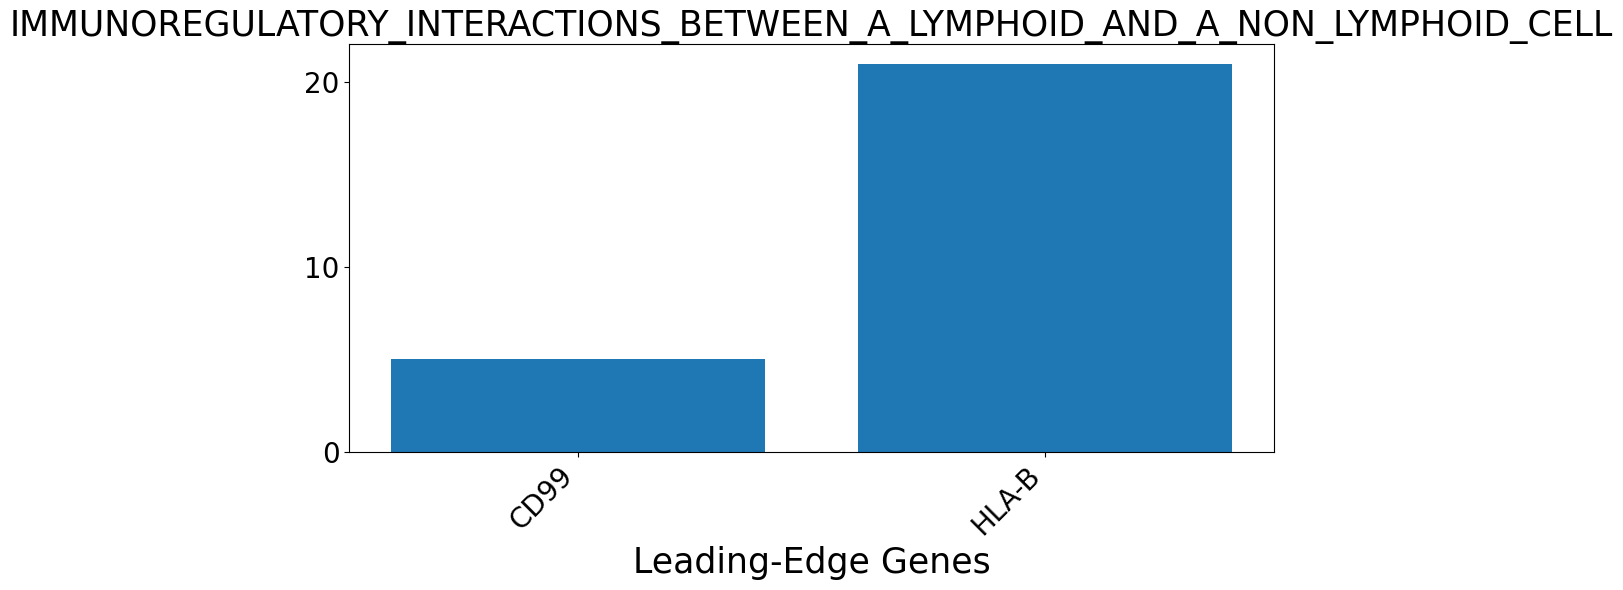

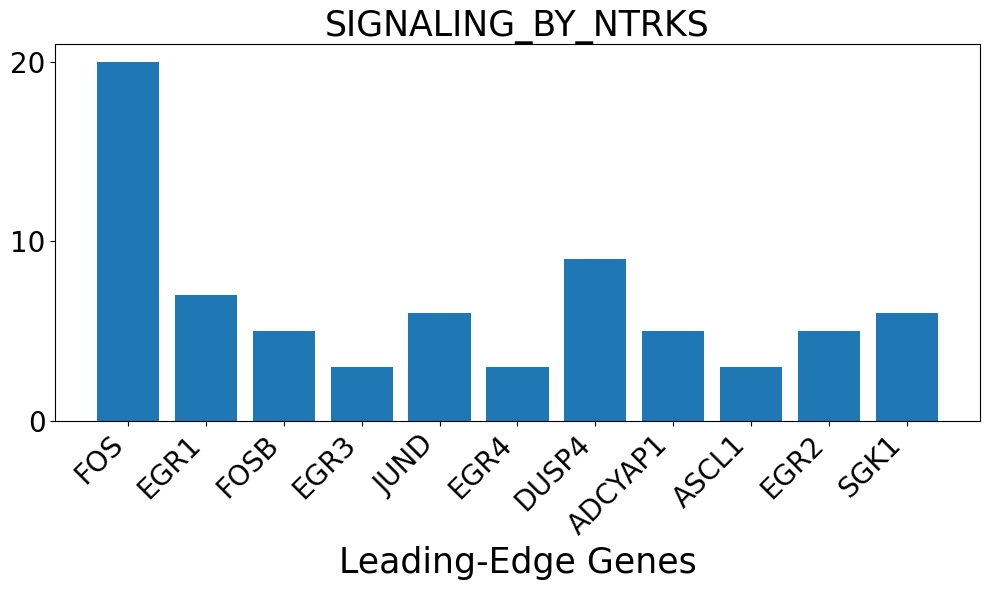

In [16]:
titles=[]
for pathway in top_by_method['GSEA']:
    # title='ANTIGEN_PROCESSING_AND_PRESENTATION'
    # delete the prefix KEGG_ or REACTOME_ for better visualization
    if pathway.startswith('KEGG_'):
        title=pathway.replace('KEGG_','')
    elif pathway.startswith('REACTOME_'):
        title=pathway.replace('REACTOME_','')
    else:
        title=pathway
    plot_leading_edge_genes(res, pathway, gene2dict, title)
    # plt.savefig(f'results/real_exp/processed_hpap/{cell_type}_{title}_leading_edge_genes_other_pathways.pdf')

# Alpha cells

## load data

In [5]:
# load results
cell_type = 'Alpha'
top5_by_method, model, all_top5_pathways,methods_results=load_results(cell_type,n_top=5)

# # load data
# adata = sc.read_h5ad('data/T1D/processed_hpap.h5ad')
# adata=adata[adata.obs['diabetes_status'].isin(['ND','AAB+']) & (adata.obs['cell_type']==cell_type)]

# degs_up, degs_dw = load_DEGs(adata,cell_type)

scKnockPath selects 34 pathways under FDR 0.2
✅ PADOG结果加载成功: 42 通路
✅ GSEA结果加载成功: 75 通路
✅ CAMERA结果加载成功: 0 通路
✅ SCPA结果加载成功: 92 通路

总共加载了 5 种方法的结果


In [12]:
top5_by_method

{'PADOG': ['REACTOME_CELLULAR_RESPONSES_TO_STIMULI',
  'REACTOME_NGF_STIMULATED_TRANSCRIPTION',
  'REACTOME_NUCLEAR_EVENTS_KINASE_AND_TRANSCRIPTION_FACTOR_ACTIVATION',
  'REACTOME_SIGNALING_BY_NTRKS',
  'KEGG_MAPK_SIGNALING_PATHWAY'],
 'GSEA': ['REACTOME_SARS_COV_2_INFECTION',
  'REACTOME_CELLULAR_RESPONSES_TO_STIMULI',
  'KEGG_REGULATION_OF_ACTIN_CYTOSKELETON',
  'KEGG_VASCULAR_SMOOTH_MUSCLE_CONTRACTION',
  'KEGG_CHRONIC_MYELOID_LEUKEMIA'],
 'CAMERA': [],
 'SCPA': ['REACTOME_INFECTIOUS_DISEASE',
  'REACTOME_CELLULAR_RESPONSES_TO_STIMULI',
  'REACTOME_SARS_COV_INFECTIONS',
  'REACTOME_HEMOSTASIS',
  'REACTOME_DEVELOPMENTAL_BIOLOGY'],
 'scKnockPath': ['REACTOME_ANTIMICROBIAL_PEPTIDES',
  'REACTOME_METABOLISM_OF_VITAMINS_AND_COFACTORS',
  'REACTOME_NGF_STIMULATED_TRANSCRIPTION',
  'REACTOME_BIOLOGICAL_OXIDATIONS',
  'REACTOME_REGULATION_OF_INSULIN_LIKE_GROWTH_FACTOR_IGF_TRANSPORT_AND_UPTAKE_BY_INSULIN_LIKE_GROWTH_FACTOR_BINDING_PROTEINS_IGFBPS']}

## W scores

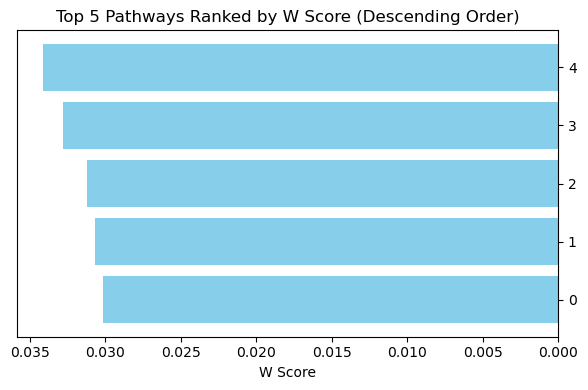

In [4]:
import matplotlib.pyplot as plt

# Get the ranked pathways in descending order
ranked = model.rank_pathways()[-5:]

# replace long pathway names with short ones for better visualization
short_names = {
    'REACTOME_REGULATION_OF_INSULIN_LIKE_GROWTH_FACTOR_IGF_TRANSPORT_AND_UPTAKE_BY_INSULIN_LIKE_GROWTH_FACTOR_BINDING_PROTEINS_IGFBPS':'REACTOME_INSULIN_IGFBPS*',
    'REACTOME_NUCLEAR_EVENTS_KINASE_AND_TRANSCRIPTION_FACTOR_ACTIVATION':'REACTOME_KINASE_AND_TRANSCRIPTION_FACTOR*',
    'REACTOME_IMMUNOREGULATORY_INTERACTIONS_BETWEEN_A_LYMPHOID_AND_A_NON_LYMPHOID_CELL':'REACTOME_INTERACTIONS_LYMPHOID*'
}

# Assuming 'ranked' is a DataFrame with columns like 'pathway_names' and 'scores'
# If it's a dict, adjust accordingly
if hasattr(ranked, 'columns'):
    pathways = ranked['pathway_names'] if 'pathway_names' in ranked.columns else ranked.index
    scores = ranked['scores'] if 'scores' in ranked.columns else ranked.values
else:
    pathways = list(ranked.keys())
    scores = list(ranked.values())

# Apply short names mapping
short_pathways = [short_names.get(p, p) for p in pathways]

# Further shorten for display by removing prefixes
display_labels = [p.replace('REACTOME_', '').replace('KEGG_', '') for p in short_pathways]

# Plot horizontal bar chart
plt.figure(figsize=(6, 4))
plt.barh(range(len(display_labels)), scores, color='skyblue')
# plt.yticks(range(len(display_labels)), display_labels, fontsize=10)
plt.xlabel('W Score')
plt.title('Top 5 Pathways Ranked by W Score (Descending Order)')

# Reverse the x-axis and move y-ticks to the right
ax = plt.gca()
ax.invert_xaxis()
ax.yaxis.set_ticks_position('right')
ax.yaxis.set_label_position('right')

plt.tight_layout()
plt.savefig(f'results/real_exp/processed_hpap/{cell_type}_top5_pathways_wscore.pdf')
plt.show()

In [11]:
ranked['pathway_names'].tolist()

['REACTOME_REGULATION_OF_INSULIN_LIKE_GROWTH_FACTOR_IGF_TRANSPORT_AND_UPTAKE_BY_INSULIN_LIKE_GROWTH_FACTOR_BINDING_PROTEINS_IGFBPS',
 'REACTOME_BIOLOGICAL_OXIDATIONS',
 'REACTOME_NGF_STIMULATED_TRANSCRIPTION',
 'REACTOME_METABOLISM_OF_VITAMINS_AND_COFACTORS',
 'REACTOME_ANTIMICROBIAL_PEPTIDES']

In [5]:
# Get the top pathways from scKnockPath
top_pathways = ranked['pathway_names'].tolist()

# Methods to check ranks in
other_methods = ['PADOG', 'GSEA', 'CAMERA', 'SCPA']

# Initialize the result dict
pathway_ranks = {}

for pathway in top_pathways:
    ranks = {}
    for method in other_methods:
        df = methods_results[method]
        col = 'Term' if method == 'GSEA' else 'Pathway'
        if pathway in df[col].values:
            rank = df[col].tolist().index(pathway) + 1  # 1-based rank
        else:
            rank = None  # Not in top results
        ranks[method] = rank
    pathway_ranks[pathway] = ranks

pathway_ranks

{'REACTOME_REGULATION_OF_INSULIN_LIKE_GROWTH_FACTOR_IGF_TRANSPORT_AND_UPTAKE_BY_INSULIN_LIKE_GROWTH_FACTOR_BINDING_PROTEINS_IGFBPS': {'PADOG': 9,
  'GSEA': 16,
  'CAMERA': None,
  'SCPA': 25},
 'REACTOME_BIOLOGICAL_OXIDATIONS': {'PADOG': None,
  'GSEA': 12,
  'CAMERA': None,
  'SCPA': None},
 'REACTOME_NGF_STIMULATED_TRANSCRIPTION': {'PADOG': 2,
  'GSEA': None,
  'CAMERA': None,
  'SCPA': 37},
 'REACTOME_METABOLISM_OF_VITAMINS_AND_COFACTORS': {'PADOG': None,
  'GSEA': 8,
  'CAMERA': None,
  'SCPA': 75},
 'REACTOME_ANTIMICROBIAL_PEPTIDES': {'PADOG': None,
  'GSEA': None,
  'CAMERA': None,
  'SCPA': None}}

In [ ]:
top5_by_method

{'PADOG': ['REACTOME_CELLULAR_RESPONSES_TO_STIMULI',
  'REACTOME_NGF_STIMULATED_TRANSCRIPTION',
  'REACTOME_NUCLEAR_EVENTS_KINASE_AND_TRANSCRIPTION_FACTOR_ACTIVATION',
  'REACTOME_SIGNALING_BY_NTRKS',
  'KEGG_MAPK_SIGNALING_PATHWAY'],
 'GSEA': ['REACTOME_SARS_COV_2_INFECTION',
  'REACTOME_CELLULAR_RESPONSES_TO_STIMULI',
  'KEGG_REGULATION_OF_ACTIN_CYTOSKELETON',
  'KEGG_VASCULAR_SMOOTH_MUSCLE_CONTRACTION',
  'KEGG_CHRONIC_MYELOID_LEUKEMIA'],
 'CAMERA': [],
 'SCPA': ['REACTOME_INFECTIOUS_DISEASE',
  'REACTOME_CELLULAR_RESPONSES_TO_STIMULI',
  'REACTOME_SARS_COV_INFECTIONS',
  'REACTOME_HEMOSTASIS',
  'REACTOME_DEVELOPMENTAL_BIOLOGY'],
 'scKnockPath': ['REACTOME_ANTIMICROBIAL_PEPTIDES',
  'REACTOME_METABOLISM_OF_VITAMINS_AND_COFACTORS',
  'REACTOME_NGF_STIMULATED_TRANSCRIPTION',
  'REACTOME_BIOLOGICAL_OXIDATIONS',
  'REACTOME_REGULATION_OF_INSULIN_LIKE_GROWTH_FACTOR_IGF_TRANSPORT_AND_UPTAKE_BY_INSULIN_LIKE_GROWTH_FACTOR_BINDING_PROTEINS_IGFBPS']}

## GSEA reuslts

In [13]:
# plot the GSEA results for REACTOME_REGULATION_OF_INSULIN_LIKE_GROWTH_FACTOR_IGF_TRANSPORT_AND_UPTAKE_BY_INSULIN_LIKE_GROWTH_FACTOR_BINDING_PROTEINS_IGFBPS
import gseapy as gp
def GSEA_test(adata,layer,gs_filepath,gene_names,obs_y,gene_thresh):

    adata.layers['lognorm'] = adata.layers[layer] if layer is not None else adata.X

    if hasattr(adata.layers['lognorm'], "toarray"):
        X = adata.layers['lognorm'].toarray()
    else:
        X = adata.layers['lognorm']
    
    if gene_names is not None: 
        adata.var_names = adata.var[gene_names].astype(str)
    
    df = pd.DataFrame(X, columns=adata.var_names)
    geneset_dict = gp.read_gmt(gs_filepath)
    
    res = gp.gsea(
        data=df.T,
        gene_sets=geneset_dict,
        cls=adata.obs[obs_y],
        permutation_num=1000,
        method='signal_to_noise',
        min_size=gene_thresh,
        seed=42
    )
    
    return res

data_filename='./data/T1D/processed_hpap.h5ad'
cell_type='Alpha'
class1='AAB+'
class2='ND'
layer='lognorm'
geneset_path='/disk/tanbowen/scKnockPath/data/pathway_db/reactome_kegg.gmt'
gene_thresh=15
gene_names=None
obs_y='diabetes_status'
fdr=0.2

adata=sc.read_h5ad(data_filename)
adata = adata[adata.obs['cell_type'] == cell_type, :]
adata=adata[(adata.obs[obs_y]==class2)|(adata.obs[obs_y]==class1),:]



In [14]:
res=GSEA_test(adata=adata,layer=None,gs_filepath=geneset_path,gene_names=gene_names, obs_y=obs_y, gene_thresh=gene_thresh)

/tmp/ipykernel_1818691/2302005215.py:5: ImplicitModificationWarning: Setting element `.layers['lognorm']` of view, initializing view as actual.
  adata.layers['lognorm'] = adata.layers[layer] if layer is not None else adata.X


In [15]:
import pickle
with open(f'results/real_exp/processed_hpap/GSEA_res_{cell_type}.pkl', 'wb') as f:
    pickle.dump(res, f)


In [3]:
with open('results/real_exp/processed_hpap/GSEA_res_Alpha.pkl', 'rb') as f:
    res = pickle.load(f)

/tmp/ipykernel_2120668/3663185669.py:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


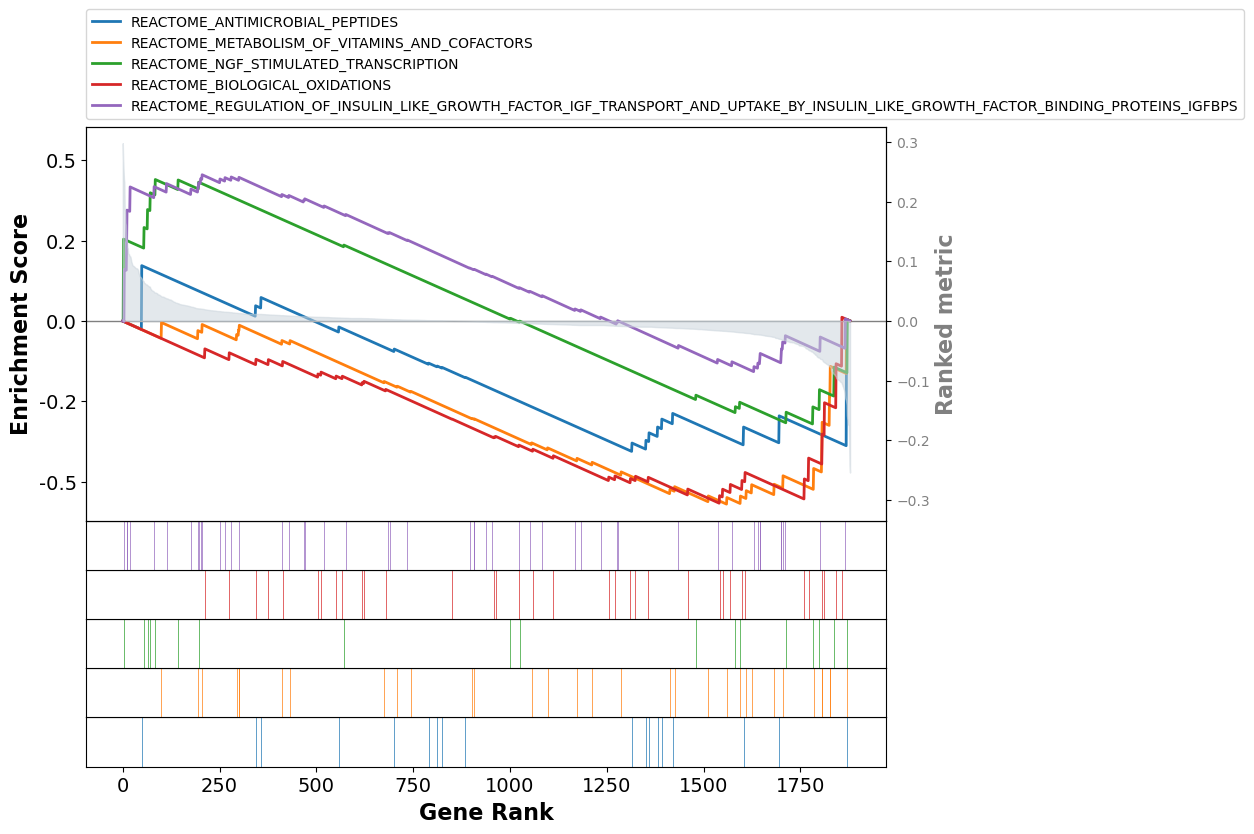

In [5]:



fig = res.plot(terms=top5_by_method['scKnockPath'])  # 返回的为 matplotlib.figure.Figure

# 可根据需要调整尺寸
fig.set_size_inches(10, 8)

# 保证布局并保存完整内容
fig.tight_layout()
fig.savefig(f'results/real_exp/processed_hpap/{cell_type}_scKP_top5_pathways.pdf', bbox_inches='tight', pad_inches=0.05, dpi=300)

/tmp/ipykernel_2120668/3452007041.py:10: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


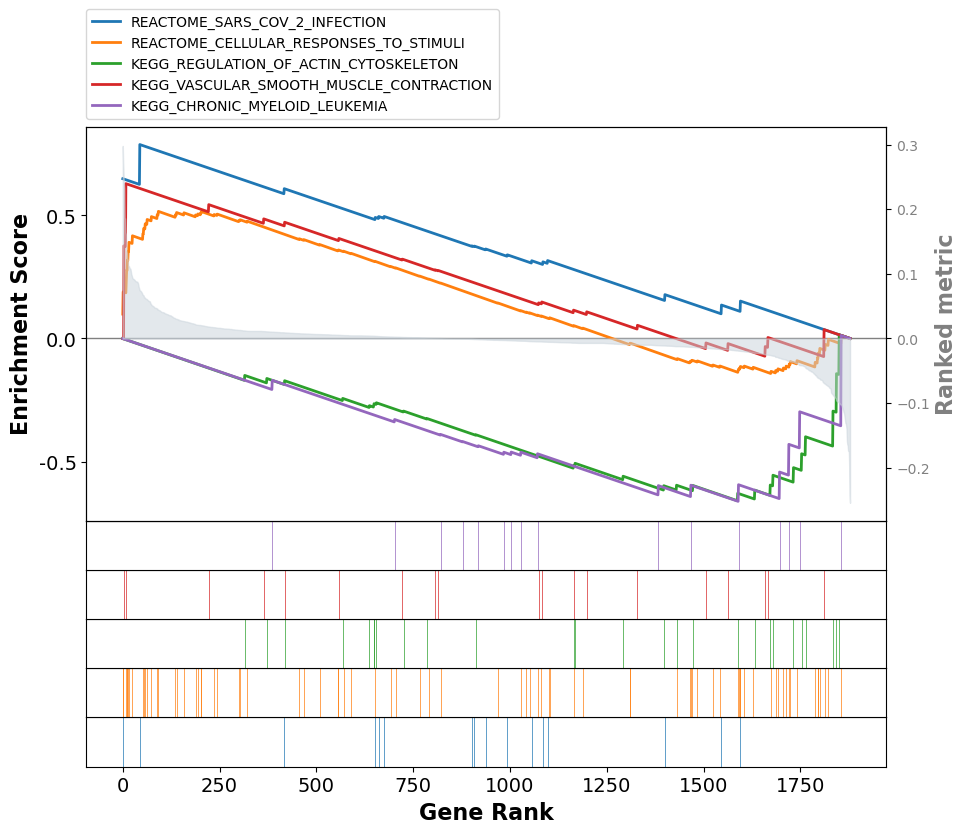

In [4]:
# 保存完整 PDF（使用返回的 Figure 对象并使用 tight bbox）
term = res.res2d.Term

fig = res.plot(terms=term[:5])  # 返回的为 matplotlib.figure.Figure

# 可根据需要调整尺寸
fig.set_size_inches(10, 8)

# 保证布局并保存完整内容
fig.tight_layout()
fig.savefig(f'results/real_exp/processed_hpap/{cell_type}_GSEA_top5_pathways.pdf', bbox_inches='tight', pad_inches=0.05, dpi=300)

## Genes Frequency

In [4]:
gene2dict=model.transform_geneset_dict()
# model.pathway_dict

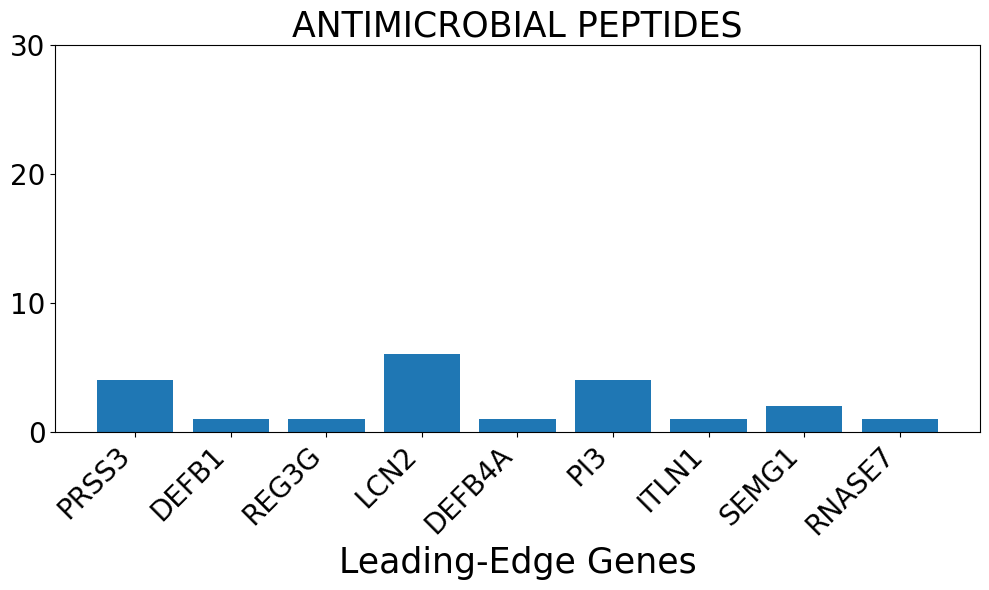

In [5]:


import matplotlib.pyplot as plt

def plot_leading_edge_genes(res, target_pathway, gene2dict,title=None):
    # Compute the number of other pathways for each gene in DEGs
    DEGs = res.res2d[res.res2d['Term'] == target_pathway]['Lead_genes'].iloc[0].split(';')
    other_pathway_counts = []
    for gene in DEGs:
        pathways = gene2dict.get(gene, [])
        other_pathways = [p for p in pathways if p != target_pathway]
        count = len(other_pathways)
        other_pathway_counts.append(count)

    plt.figure(figsize=(10, 6))
    plt.bar(range(len(DEGs)), other_pathway_counts, tick_label=DEGs)
    plt.xlabel('Leading-Edge Genes',size=25)
    if title:
        plt.title(title,size=25)
    plt.xticks(rotation=45, ha='right', size=20)
    plt.yticks([0,10,20,30],size=20)
    plt.tight_layout()
    
target_pathway='REACTOME_ANTIMICROBIAL_PEPTIDES'
title='ANTIMICROBIAL PEPTIDES'
plot_leading_edge_genes(res, target_pathway, gene2dict, title)
plt.savefig(f'results/real_exp/processed_hpap/{cell_type}_{title}_leading_edge_genes_other_pathways.pdf')



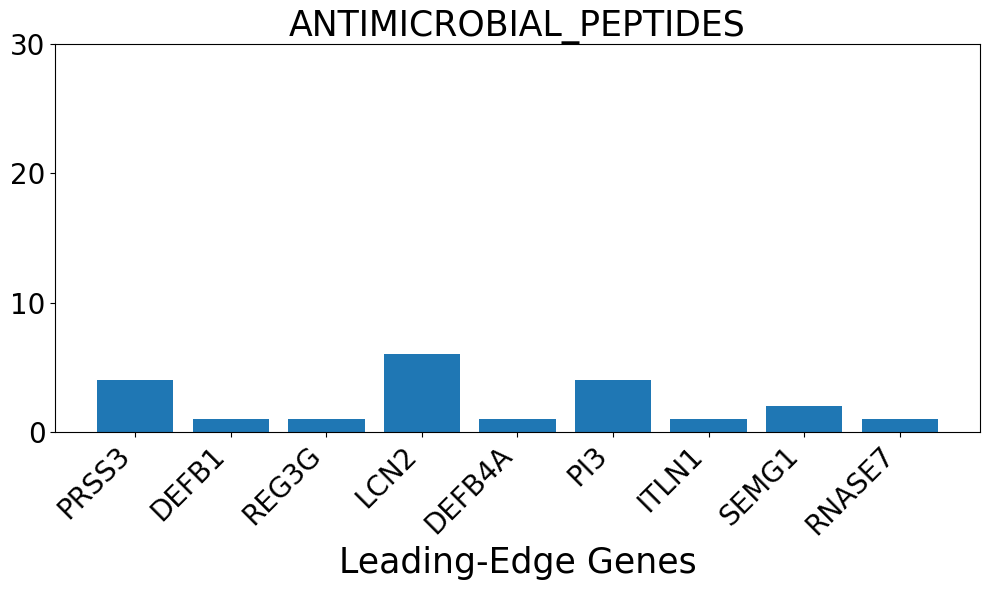

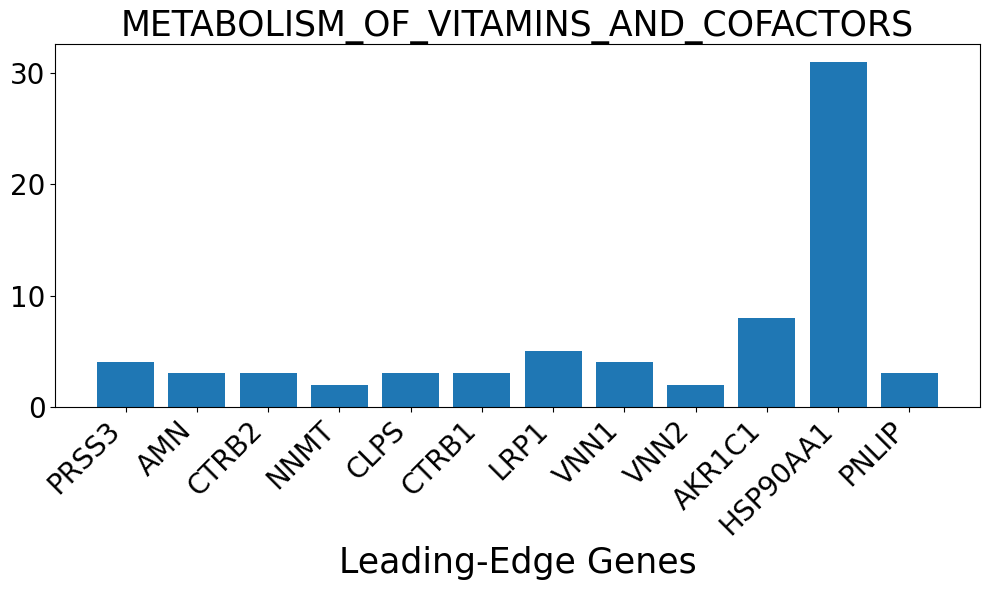

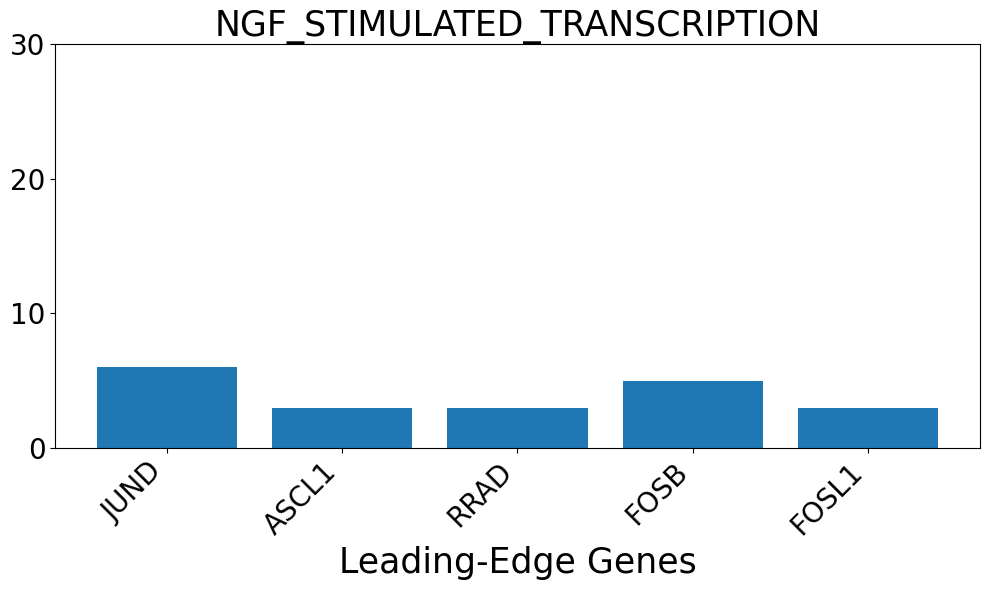

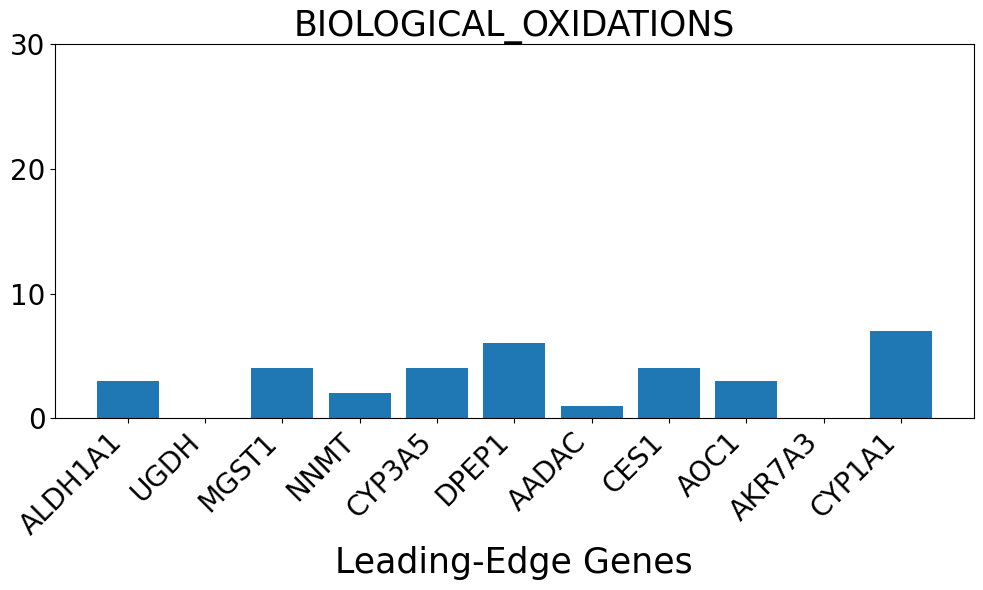

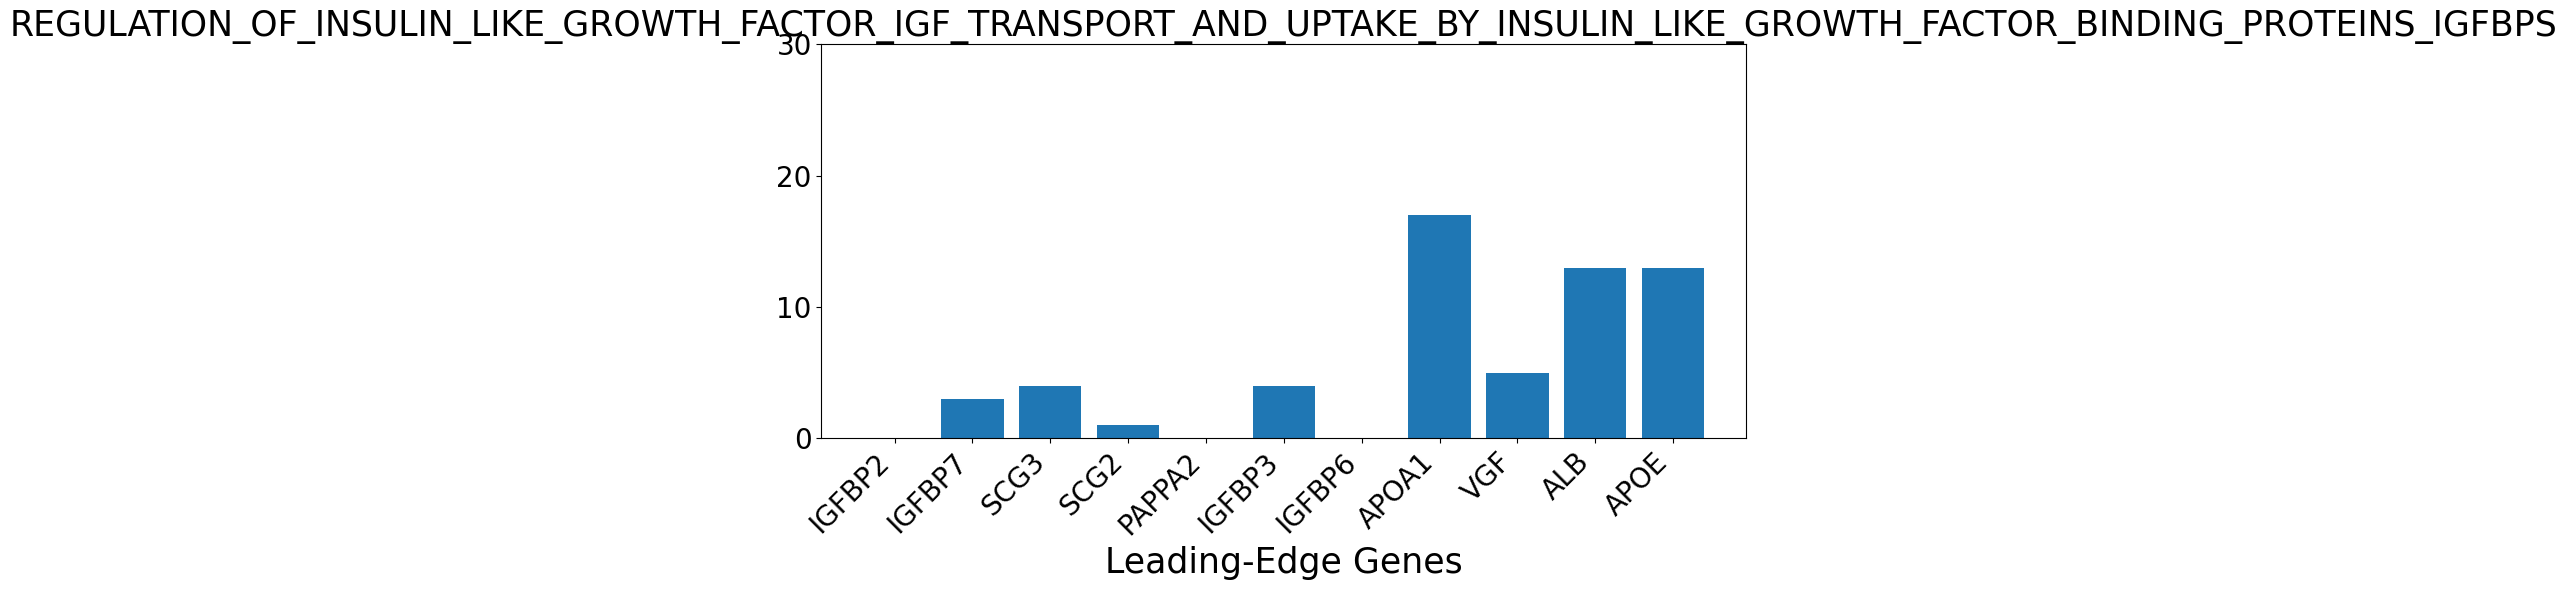

In [6]:
short_names = {
    'REACTOME_REGULATION_OF_INSULIN_LIKE_GROWTH_FACTOR_IGF_TRANSPORT_AND_UPTAKE_BY_INSULIN_LIKE_GROWTH_FACTOR_BINDING_PROTEINS_IGFBPS':'REACTOME_INSULIN_IGFBPS*',
    'REACTOME_NUCLEAR_EVENTS_KINASE_AND_TRANSCRIPTION_FACTOR_ACTIVATION':'REACTOME_KINASE_AND_TRANSCRIPTION_FACTOR*',
    'REACTOME_IMMUNOREGULATORY_INTERACTIONS_BETWEEN_A_LYMPHOID_AND_A_NON_LYMPHOID_CELL':'REACTOME_INTERACTIONS_LYMPHOID*'
}

for pathway in top5_by_method['scKnockPath']:
    # title='ANTIGEN_PROCESSING_AND_PRESENTATION'
    # delete the prefix KEGG_ or REACTOME_ for better visualization
    title=short_names[pathway] if pathway in short_names else pathway
    if pathway.startswith('KEGG_'):
        title=pathway.replace('KEGG_','')
    elif pathway.startswith('REACTOME_'):
        title=pathway.replace('REACTOME_','')
    else:
        title=pathway
        
    plot_leading_edge_genes(res, pathway, gene2dict, title)
    plt.savefig(f'results/real_exp/processed_hpap/scKnockPath_results/{cell_type}_{title}_leading_edge_genes_other_pathways.pdf')

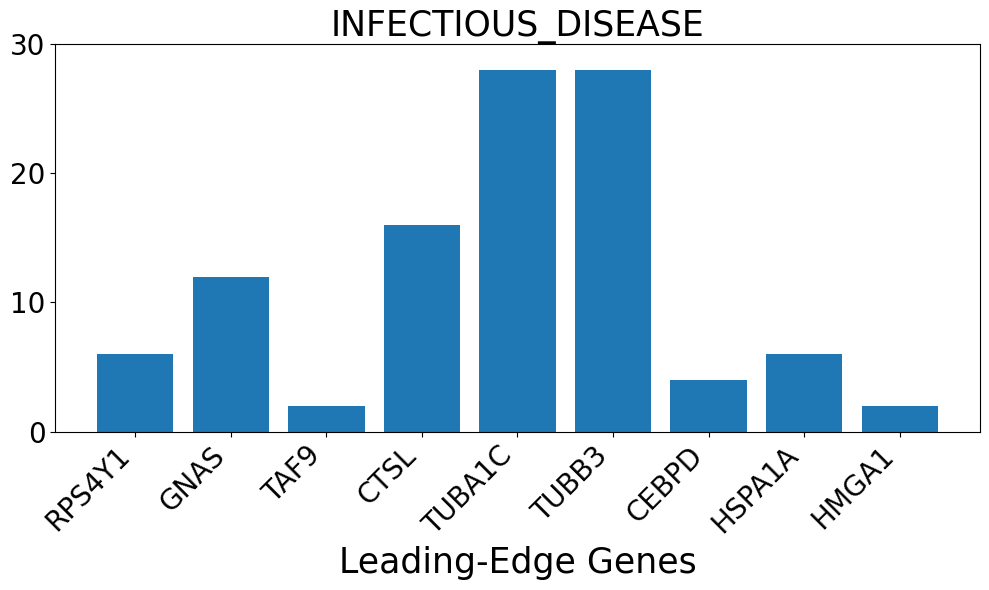

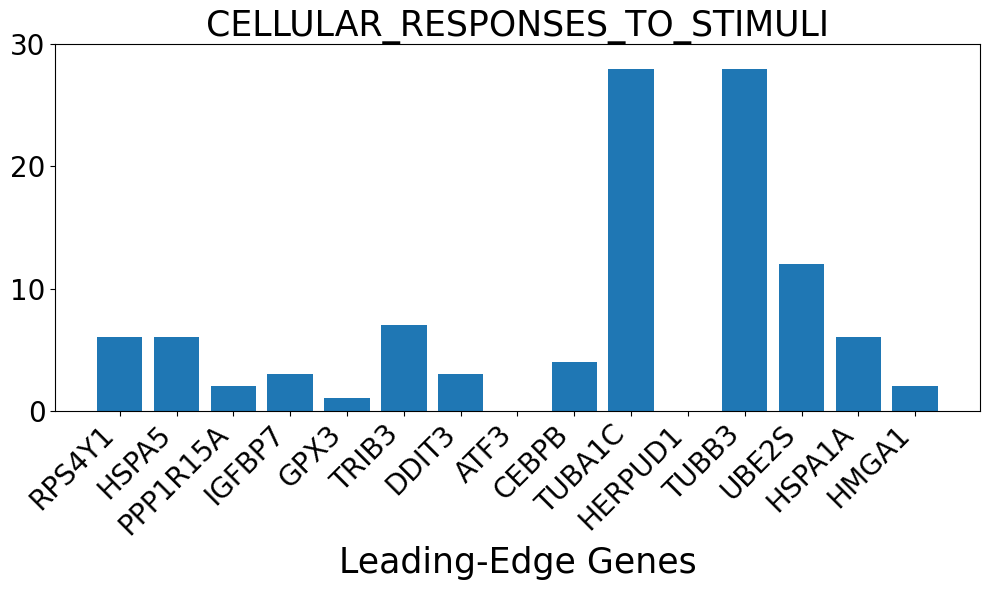

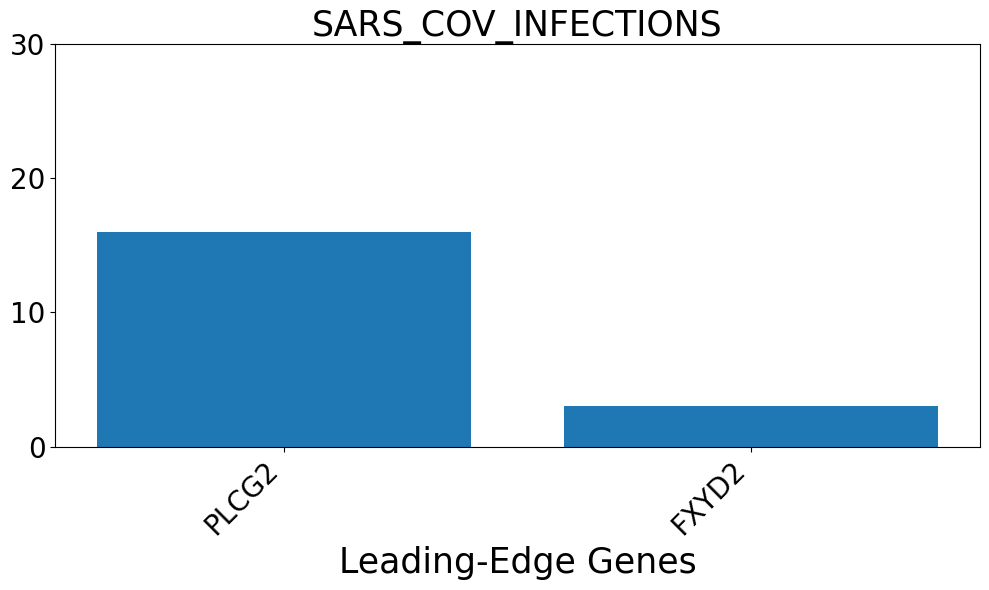

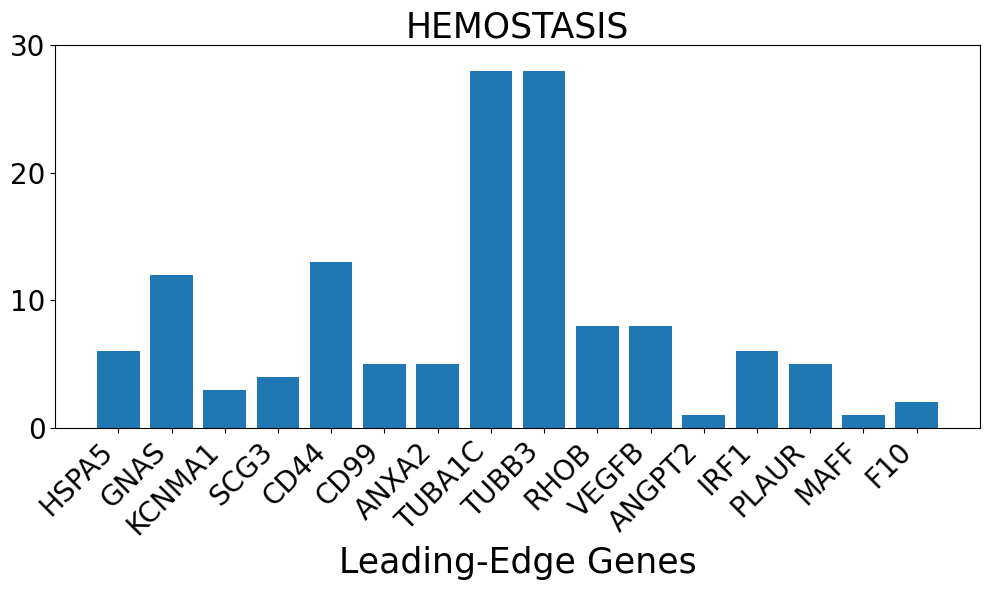

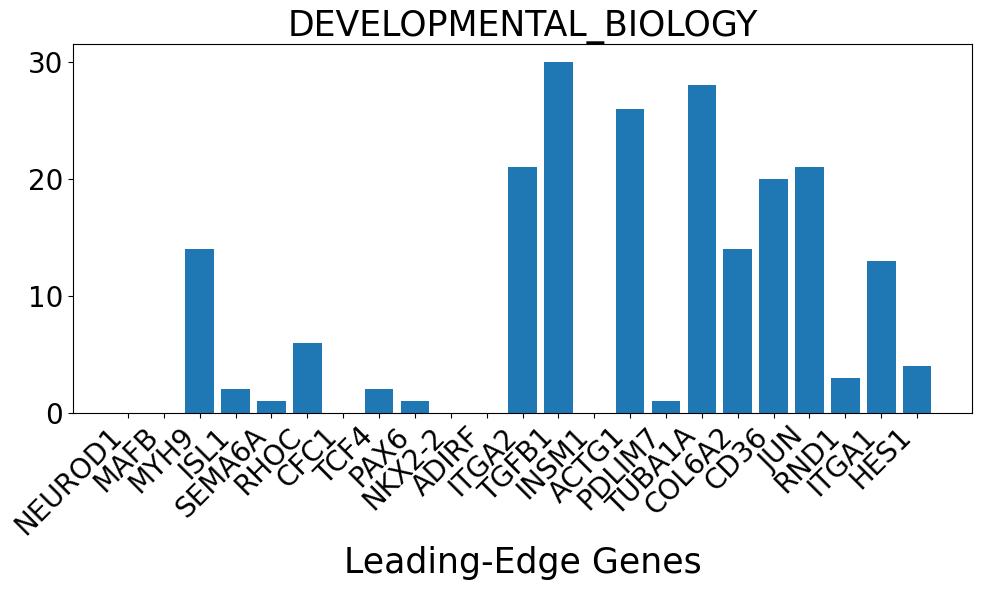

In [8]:
short_names = {
    'REACTOME_REGULATION_OF_INSULIN_LIKE_GROWTH_FACTOR_IGF_TRANSPORT_AND_UPTAKE_BY_INSULIN_LIKE_GROWTH_FACTOR_BINDING_PROTEINS_IGFBPS':'REACTOME_INSULIN_IGFBPS*',
    'REACTOME_NUCLEAR_EVENTS_KINASE_AND_TRANSCRIPTION_FACTOR_ACTIVATION':'REACTOME_KINASE_AND_TRANSCRIPTION_FACTOR*',
    'REACTOME_IMMUNOREGULATORY_INTERACTIONS_BETWEEN_A_LYMPHOID_AND_A_NON_LYMPHOID_CELL':'REACTOME_INTERACTIONS_LYMPHOID*'
}

for pathway in top5_by_method['SCPA']:
    # title='ANTIGEN_PROCESSING_AND_PRESENTATION'
    # delete the prefix KEGG_ or REACTOME_ for better visualization
    title=short_names[pathway] if pathway in short_names else pathway
    if pathway.startswith('KEGG_'):
        title=pathway.replace('KEGG_','')
    elif pathway.startswith('REACTOME_'):
        title=pathway.replace('REACTOME_','')
    else:
        title=pathway
        
    plot_leading_edge_genes(res, pathway, gene2dict, title)

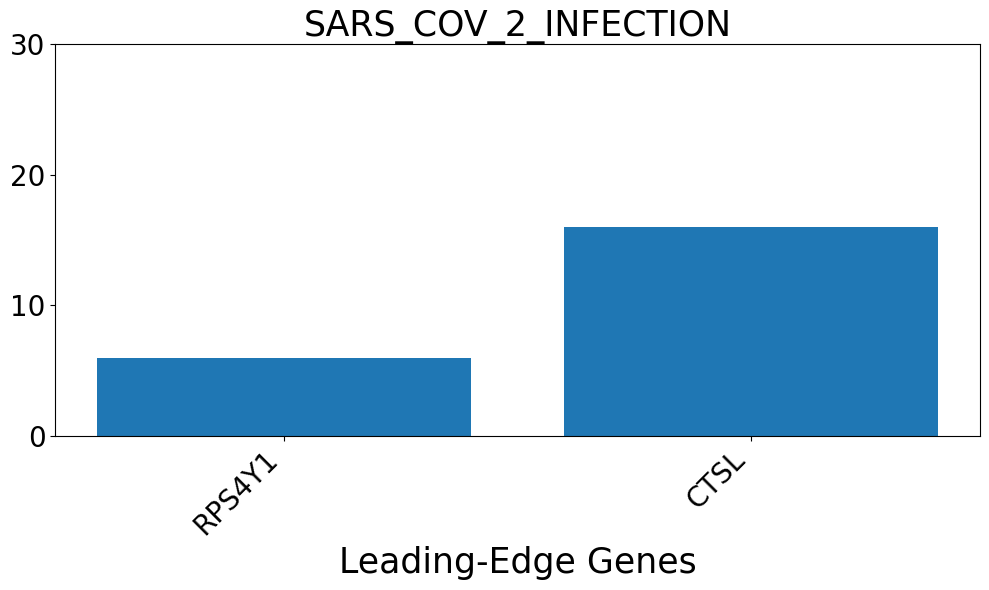

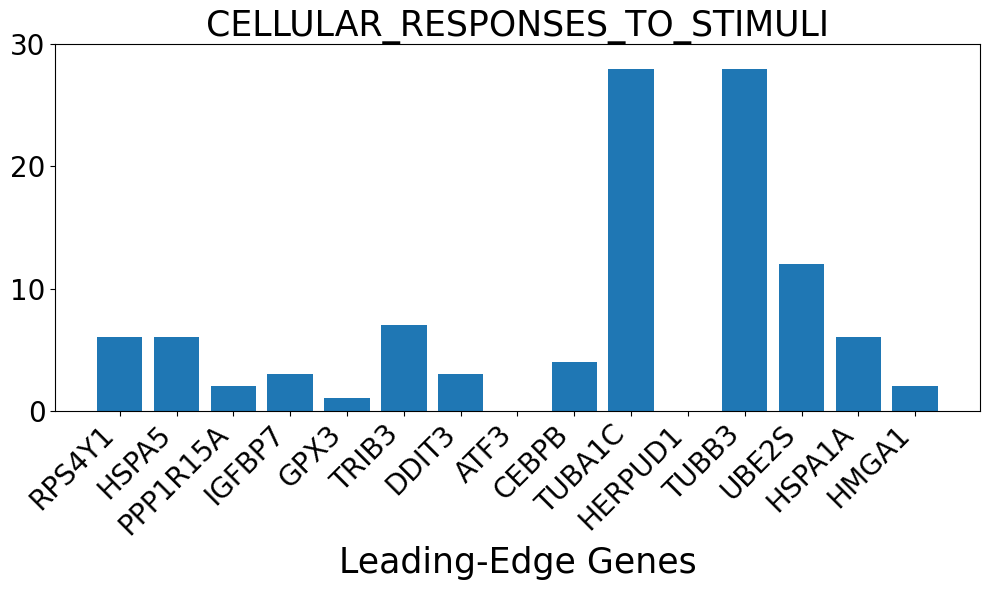

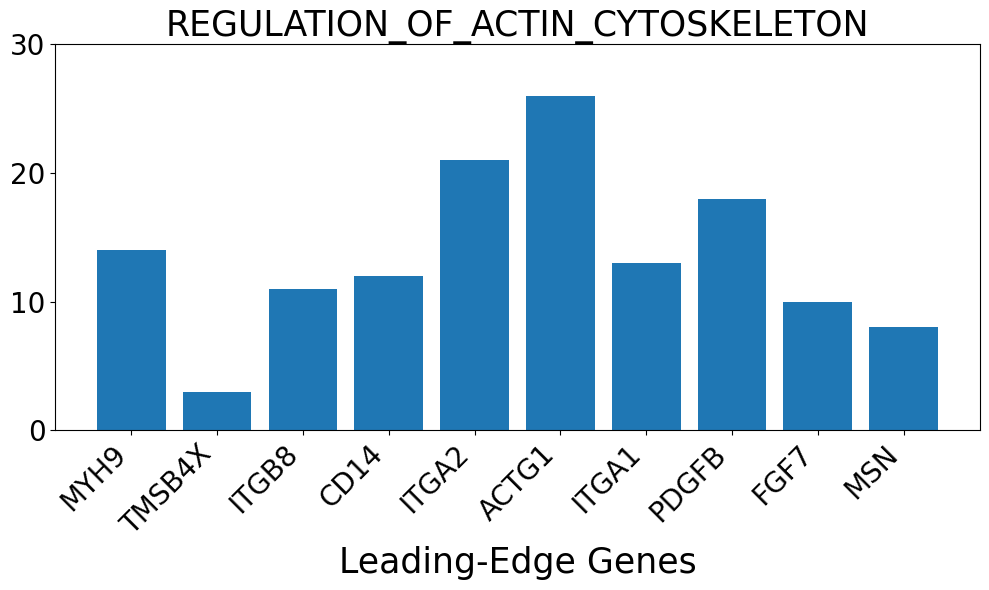

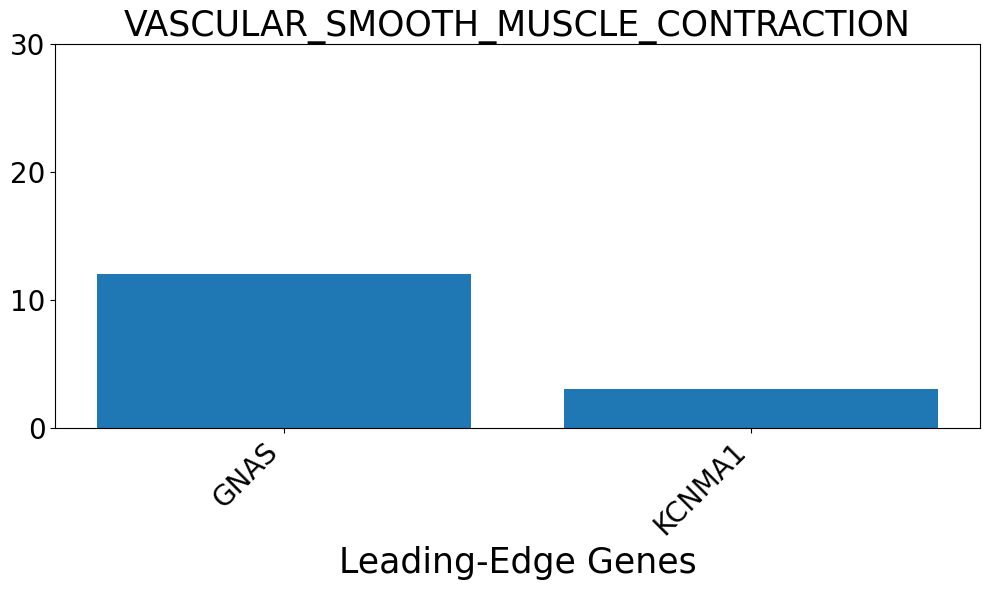

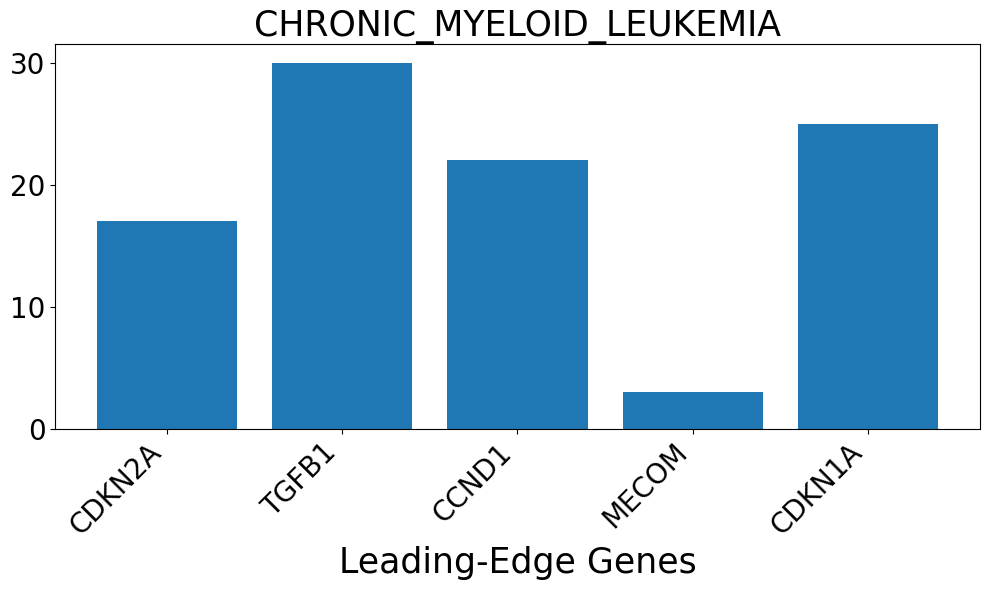

In [7]:
short_names = {
    'REACTOME_REGULATION_OF_INSULIN_LIKE_GROWTH_FACTOR_IGF_TRANSPORT_AND_UPTAKE_BY_INSULIN_LIKE_GROWTH_FACTOR_BINDING_PROTEINS_IGFBPS':'REACTOME_INSULIN_IGFBPS*',
    'REACTOME_NUCLEAR_EVENTS_KINASE_AND_TRANSCRIPTION_FACTOR_ACTIVATION':'REACTOME_KINASE_AND_TRANSCRIPTION_FACTOR*',
    'REACTOME_IMMUNOREGULATORY_INTERACTIONS_BETWEEN_A_LYMPHOID_AND_A_NON_LYMPHOID_CELL':'REACTOME_INTERACTIONS_LYMPHOID*'
}

for pathway in top5_by_method['GSEA']:
    # title='ANTIGEN_PROCESSING_AND_PRESENTATION'
    # delete the prefix KEGG_ or REACTOME_ for better visualization
    title=short_names[pathway] if pathway in short_names else pathway
    if pathway.startswith('KEGG_'):
        title=pathway.replace('KEGG_','')
    elif pathway.startswith('REACTOME_'):
        title=pathway.replace('REACTOME_','')
    else:
        title=pathway
        
    plot_leading_edge_genes(res, pathway, gene2dict, title)
    # plt.savefig(f'results/real_exp/processed_hpap/scKnockPath_results/{cell_type}_{title}_leading_edge_genes_other_pathways.pdf')

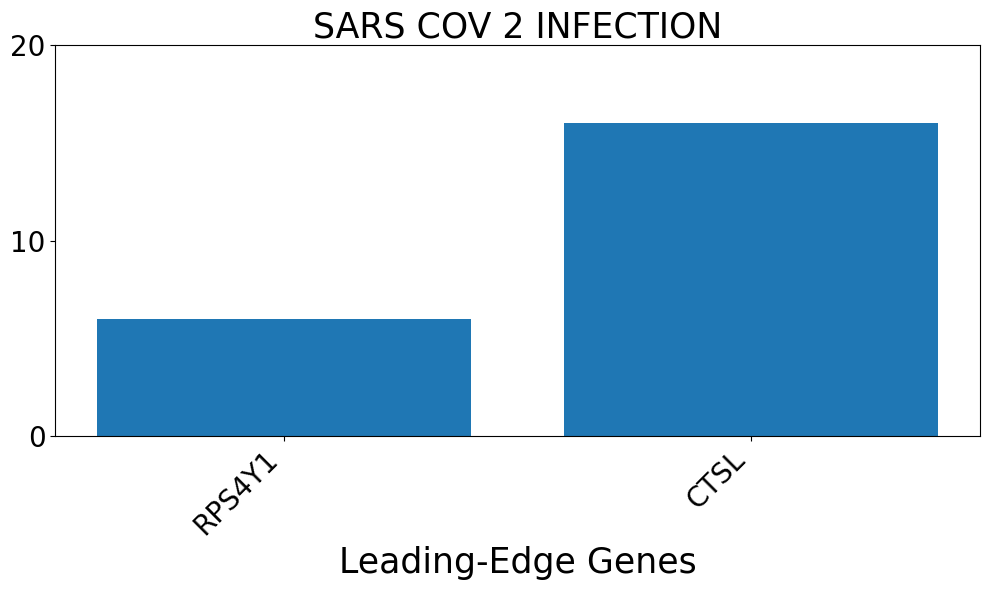

In [10]:
target_pathway='REACTOME_SARS_COV_2_INFECTION'
title='SARS COV 2 INFECTION'
plot_leading_edge_genes(res, target_pathway, gene2dict, title)
plt.savefig(f'results/real_exp/processed_hpap/{cell_type}_{title}_leading_edge_genes_other_pathways.pdf')


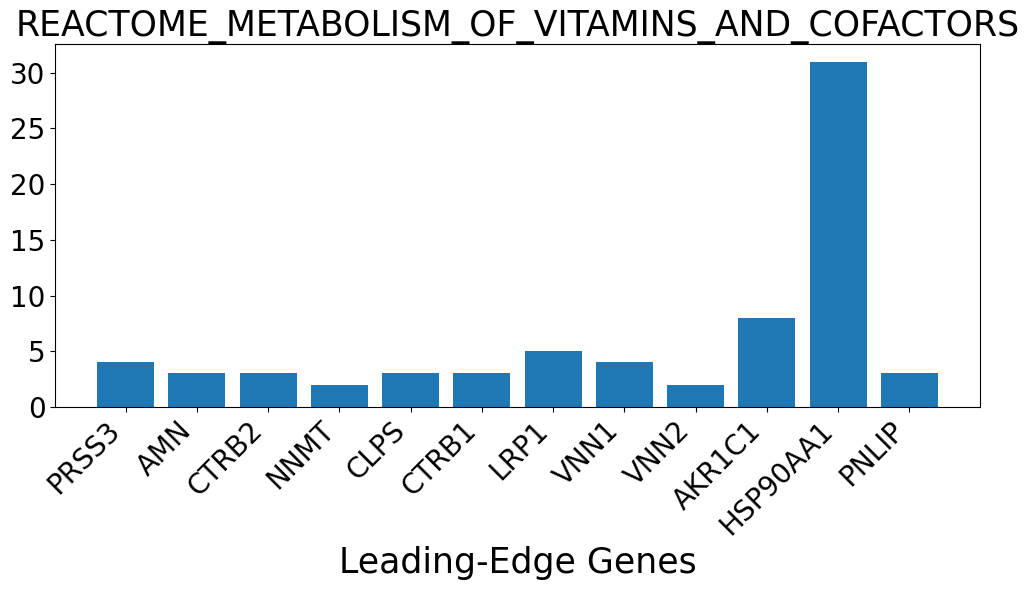

In [22]:
target_pathway=['REACTOME_METABOLISM_OF_VITAMINS_AND_COFACTORS']

import matplotlib.pyplot as plt

# Compute the number of other pathways for each gene in DEGs
DEGs = res.res2d[res.res2d['Term'] == target_pathway[0]]['Lead_genes'].iloc[0].split(';')
other_pathway_counts = []
for gene in DEGs:
    pathways = gene2dict.get(gene, [])
    other_pathways = [p for p in pathways if p != target_pathway[0]]
    count = len(other_pathways)
    other_pathway_counts.append(count)

plt.figure(figsize=(10, 6))
plt.bar(range(len(DEGs)), other_pathway_counts, tick_label=DEGs)
plt.xlabel('Leading-Edge Genes',size=25)
plt.title(f'{target_pathway[0]}',size=25)
plt.xticks(rotation=45, ha='right', size=20)
plt.yticks(size=20)
plt.tight_layout()
plt.savefig(f'results/real_exp/processed_hpap/{cell_type}_{target_pathway[0]}_leading_edge_genes_other_pathways.pdf')
plt.show()